# | Imports, functions & data load

## | Reset variables

Notebook variables reset for each complete execution of this code :

In [12]:
%reset -f

## | Installations & Imports

### | Installations

In [3]:
#!pip install catboost

In [4]:
#!pip install xgboost

In [5]:
#!pip install imblearn

In [6]:
#!pip install shap

In [7]:
#!pip install tqdm

In [8]:
#!pip install lightgbm

In [9]:
#!pip install -U scikit-learn

In [10]:
#!pip install imlearn #==0.9.0

### | Imports

In [13]:
import autopep8

import pandas as pd
import seaborn as sns
import numpy as np
import time
import pickle
import joblib
import matplotlib.pyplot as plt
import array as arr
from tqdm import tqdm
import sklearn
print("Scikit-Learn Version : {}".format(sklearn.__version__))

from zipfile import ZipFile

# Preprocessing, Imputing, Upsampling, Model Selection, Model Evaluation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from collections import Counter

from sklearn.pipeline import Pipeline
#from imblearn.pipeline import make_pipeline
#from imblearn.pipeline import Pipeline as imbpipeline

from imblearn.over_sampling import SMOTE #on ne peut pas le mettre dans un pipeline par ce que ça vient pas de scikit learn

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import fbeta_score, make_scorer, auc
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import get_scorer_names


#Predictive Models

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

# Interpreting Predictions

import shap
print("SHAP Version : {}".format(shap.__version__))

Scikit-Learn Version : 1.5.0
SHAP Version : 0.45.1


## | Analyse Custom Scorer | fonction métier

### | Définition du Seuil

La question que l'on doit se poser est: à partir de quel **seuil de probabilité** allons nous choisir de classer le client comme un **client de confiance** ou un **client à risques**?

**Implications métier :**

-  **Ne pas prêter** d'argent à un client qui **aurait remboursé** son prêt est un **manque à gagner** pour l'entreprise.


-  Cependant, lorsque l'entreprise **prête** à un client qui ne **pourra pas rembourser** son prêt, il s'agit d'une **perte sèche**.


-  **Risque** de prêt à client qui **ne remboursera pas** > **Gain** à prêter à un client qui **remboursera**

Il nous faut donc déterminer les **coûts** lorsque l'entreprise **prête** à un mauvais client, comparé aux **coûts** d'un **refus de prêt** à un bon client.

**FN**(Faux Bon Client): Prêt à tort ===> Perte du capital ou partie du capital ===> Perte de beaucoup d'argent<br>
**FP**(Faux Mauvais Client): Refus à tort de prêt ===> Perte de Marge, Manque à gagner

**Hypothèse:** Nous partons d'un capital de 100.

 - FN ---> Perte de 50% du capital prêté en moyenne ---> Perte de 50
 - FP ---> Manque à gagner de 1%/an sur en moyenne 10ans<br>
(capital va de 100 à 0 soit moyenne de 50) ---> 10% de 50 ---> Perte de 5

**Rapport de coût entre FN et FP:**

Les FN coûtent 10 fois plus chers que les FP, **1xFN = 10FP**

**Objectif:**

 - Optimiser la Matrice de confusion en optimisant la somme de ces 2 coûts.
 - Fonction à minimiser:

**Min(10FN + FP)**

 - Tester tous les seuils et calculer cette fonction

### | Alternatives pour la fonction coût métier

La fonction reprenant les FP et FN est créée au paragraphe:<br>
**Functions | Création de la fonction coût métier**

Une autre alternative possible est  également de créer un custom score qui impacterait plus le rappel que la précision, de type FBeta score:

In [ ]:
fthree_scorer = make_scorer(fbeta_score, beta=3)
fthree_scorer

## | Functions

### | Création de la fonction coût métier

Optimiser la Matrice de confusion en optimisant la somme de ces 2 coûts.<br>
Résoudre: Min(10FN +FP) --> fonction à minimiser

In [14]:
# fonction métier à partir de la matrice de confusion
def custom_metric(y_true, y_pred):
    """Fonction qui extrait de la matrice de confusion les
    valeurs des 4 mesures et retourne un calcul sur base
    d'une pondération de FP et FN"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (10*fn + fp)/len(y_true)

# un custom_auc
def custom_auc_metric(y_true, y_pred_proba):
    """Fonction qui permet d'utiliser les mêmes entrées que
    custom_metric sans utiliser y_pred mais y_proba à la place"""
    return roc_auc_score(y_true, y_pred_proba)

In [15]:
# creation du custom_score métier sur base du custom_metric pour guider le GridsearchCV
custom_score = make_scorer(custom_metric, greater_is_better=False)

In [16]:
# creation du custom_auc sur base du custom_auc_metric
custom_auc = make_scorer(custom_auc_metric, greater_is_better=True, needs_proba=True)

**Modification : scores = uniquement 'custom_score' (retiré custom_auc)**

In [17]:
scores = {'custom_score': custom_score}

In [18]:
scores

{'custom_score': make_scorer(custom_metric, greater_is_better=False, response_method='predict')}

### | Confusion Matrix and ROC Area Under the Curve

In [19]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, dataset):
    '''This function will make a pretty plot of a
    sklearn Confusion Matrix using a 
    Seaborn heatmap visualization + ROC Curve.'''
    
    # global indices
    fig = plt.figure(figsize=(10, 10))
    
    # plot Confusion Matrix
    plt.subplot(221)
    
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(
        value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(
        group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    
    # plot Area Under the Curve (ROC)
    plt.subplot(222)
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    # plot no-skill curve
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='No Skill')
    # plot the ROC_AUC curve
    if dataset=="train":
        plt.plot(fpr, tpr, color='orange', linewidth=5,
             label='ROC_AUC (train) = %0.4f' %roc_auc1)
    elif dataset=="test":
        plt.plot(fpr, tpr, color='orange', linewidth=5,
             label='ROC_AUC (test) = %0.4f' %roc_auc2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()

    
    # plot Area Under the Curve (Precision-Recall)
    plt.subplot(212)
    # predict class values
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    no_skill = len(y_true[y_true==1]) / len(y_true)
    # plot no-skill curve
    plt.plot([0, 1], [no_skill, no_skill], color='darkblue', linestyle='--', label='No Skill')
    # calculate precision-recall AUC
    pr_auc = auc(recall, precision)
    # plot the precision-recall curves
    if dataset=="train":
        plt.plot(recall, precision, color='orange', linewidth=5,
             label='PR_AUC (train) = %0.4f' %pr_auc)
    elif dataset=="test":
        plt.plot(recall, precision, color='orange', linewidth=5,
             label='PR_AUC (test) = %0.4f' %pr_auc)    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
    # show the plot   
    plt.show()

### | Model Comparison | Confusion Matrix and ROC / PR AUC curves

In [20]:
model_names = ["Dummy", "LogReg", "RandFor", "CatBoost", "XGBC", "LightGBM", "LightGBM_NS"]

In [21]:
def cf_matrix_compare(dataset):
    '''This function will make plot of
    Confusion Matrixes using a 
    Seaborn heatmap visualization
    for all models trained / tested.'''
    
    # global indices
    group_names = ['No Default', 'Default']
    fig, axs = plt.subplots(1, 7, figsize=(25, 5), sharey='row')
    fig.set_facecolor('lightgrey')
        
    for i, model in enumerate(model_names):
        # plot Confusion Matrixes | axs[row, col]
        if dataset=="train":
            cf_matrix = confusion_matrix(y_train, predictions_1[i])
            fig.text(0.4, 0.1, 'Predicted label (train)', ha='left')
        elif dataset=="test":
            cf_matrix = confusion_matrix(y_test, predictions_2[i])
            fig.text(0.4, 0.1, 'Predicted label (test)', ha='left')

        disp = ConfusionMatrixDisplay(cf_matrix,
                                      display_labels=group_names)

        disp.plot(ax=axs[i], xticks_rotation=45)
        disp.ax_.set_title(model)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        axs[i].grid(False)
        if i!=0:
            disp.ax_.set_ylabel('')

    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    
    fig.colorbar(disp.im_, ax=axs)
    plt.show()

In [22]:
def auc_compare(dataset):
    '''This function will make plot of a
    ROC and PR Curves of all models tested,
    and return PR_AUC values.'''
    
    # global indices
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    col = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    # instantiate dictionaries
    pr_auc_val_train=[]
    pr_auc_val_test=[]
    
    # plot Area Under the Curve (ROC)
    plt.subplot(121)
    
    for i, model in enumerate(model_names):
        # plot ROC_AUC curves
        if dataset=="train":
            fpr, tpr, _ = roc_curve(y_train, pred_proba_1[i])
            plt.plot(fpr, tpr, color=col[i], linewidth=4, label=f"{model}AUC (train) = {round(roc_auc_1[i], 4)}")
        elif dataset=="test":
            fpr, tpr, _ = roc_curve(y_test, pred_proba_2[i])
            plt.plot(fpr, tpr, color=col[i], linewidth=4, label=f"{model}AUC (test) = {round(roc_auc_2[i], 4)}")
  
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
        
    # plot Area Under the Curve (Precision-Recall)
    plt.subplot(122)
   
    for i, model in enumerate(model_names):
    # predict class values
        if dataset=="train":
            precision, recall, _ = precision_recall_curve(y_train, pred_proba_1[i])
            # calculate precision-recall AUC
            pr_auc = auc(recall, precision)
            # add pr_auc value to list for the final presentation dataframe 
            pr_auc_val_train.append(pr_auc)
            # plot the precision-recall curves
            plt.plot(recall, precision, color=col[i], linewidth=4,
                     label=f"{model}PR_AUC (train) = {round(pr_auc, 4)}")
            
        elif dataset=="test":
            precision, recall, _ = precision_recall_curve(y_test, pred_proba_2[i])
            # calculate precision-recall AUC
            pr_auc = auc(recall, precision)
            # add pr_auc value to list for the final presentation dataframe 
            pr_auc_val_test.append(pr_auc)
            # plot the precision-recall curves
            plt.plot(recall, precision, color=col[i], linewidth=4,
                     label=f"{model}PR_AUC (test) = {round(pr_auc, 4)}")

    no_skill = len(y_train[y_train==1]) / len(y_train)
    # plot no-skill curve
    plt.plot([0, 1], [no_skill, no_skill], color='darkblue', linestyle='--', label='No Skill')
    
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
    plt.show()
    
    return pr_auc_val_train, pr_auc_val_test

## | Parameters & Data load

In [23]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [24]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour bien visualiser les colonnes
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Format des graphiques seaborn
sns.set_theme(style="whitegrid")

In [25]:
z = ZipFile("data_train.zip")
data_train = pd.read_csv(z.open('data_train.csv'),
                         index_col='SK_ID_CURR', encoding='utf-8')

In [26]:
data_train.shape

(307507, 114)

In [27]:
TARGET = pd.read_csv('TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307507, 1)

In [28]:
data_train["TARGET"] = TARGET

# | Data preparation for model

## | Manual reduction of feature number

Basé sur une première itération ayant fourni des features finales peu explicatives, nous retirons ces features pour laisser place à celles ayant réellement un impact sur la TARGET:

Liste features_to_remove à compléter au besoin pour retirer des features qui ne semblent pas expliquer correctement TARGET, et qui sont juste corrélées, mais sans relation de cause à effet côté métier. 

In [29]:
# features_to_remove = []

In [30]:
# data_train[[features_to_remove]]

## | Outliers (Outliers --> np.nan --> Imputation --> median)

In [31]:
# get categorical and quantitative columns

cat_cols = list(data_train.select_dtypes(exclude=[np.number]).columns)
quant_cols = list(data_train.select_dtypes(include=[np.number]).columns)

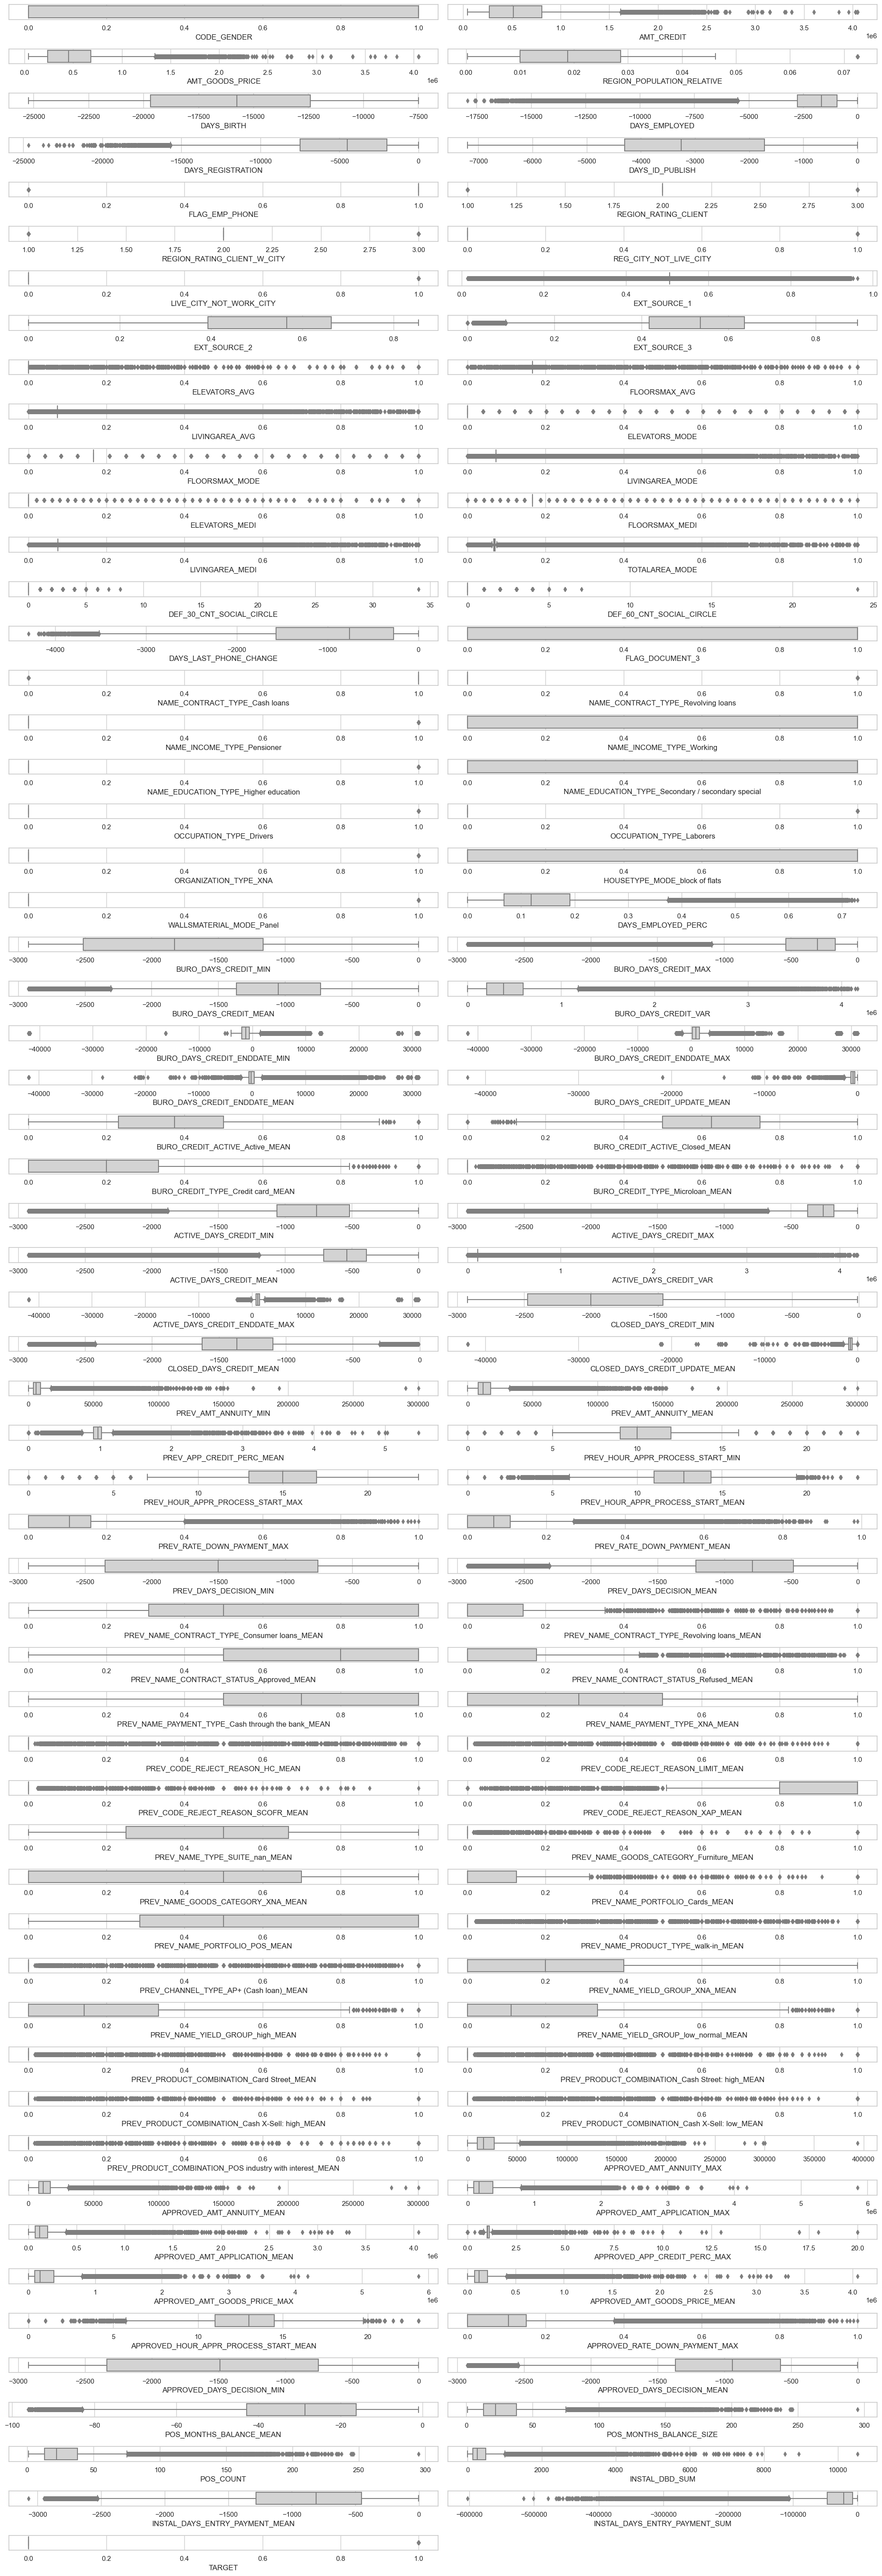

In [32]:
# Show outliers of each quantitative value

sel = quant_cols
width = 20
height = ((len(sel)+1)/2)*1

fig = plt.figure(figsize=(width, height))

for i, c in enumerate(sel,1):
    ax = fig.add_subplot((len(sel)+2)//2, 2, i)
    sns.boxplot(x=data_train[c], orient='h',
                color='lightgrey', ax=ax)
    
fig.tight_layout()

Certaines valeurs aberrantes peuvent pénaliser le processus d'apprentissage.

Nous supprimerons toutes les lignes où une valeur n'est pas comprise dans un intervalle de +/- 7 sigmas.


In [33]:
import scipy.stats as st

thresh = 7

ind_outliers = []
for col in quant_cols:
    ser_ = data_train[col]
    mask_outl = np.abs(st.zscore(ser_))>thresh
    ind_outliers.append(list(ser_.loc[mask_outl].index))

ind_outliers = list(set([i for sublist in ind_outliers for i in sublist]))

print(f"{len(ind_outliers)} rows will be dropped, i.e. \
{round(100*len(ind_outliers)/data_train.shape[0],2)}% of the rows of 'data_train'")

16197 rows will be dropped, i.e. 5.27% of the rows of 'data_train'


In [34]:
# vérification that outliers are not all of the target=1 type

print('{} of outliers are target=1'.format(round(100*data_train.loc[ind_outliers,"TARGET"].sum()/len(ind_outliers),2)))
print('{}% of all the rows are target=1'.format(round(100*data_train.loc[: ,"TARGET"].sum()/data_train.shape[0],2)))

12.02 of outliers are target=1
8.07% of all the rows are target=1


Vu le nombre de TARGET == 1 total (environ 20 000) et les lignes potentiellement supprimées (environ 5 000 soit 1/4 du total, ce qui est significatif), en retirant ces valeurs extrêmes, nous risquons de **perdre en quantité d'information sur la classe minoritaire**.

Mais le traitement des outliers est nécessaire avant d'engager un modèle de ML.<br>
Je procèderai donc à leur **imputation par la médiane**, en les **convertissant** d'abord ici en **np.nan**.

L'**imputation par la moyenne** sera effectuée pour chaque évaluation de modèle dans le **pipeline de pre-processing**.

On va donc remplacer les valeurs Outliers (trop nombreux) par des np.nan pour pouvoir ensuite les imputer par la médiane.

In [35]:
shape_0 = data_train.shape

In [36]:
import scipy.stats as st

thresh = 7

ind_outliers = []
for col in quant_cols:
    ser_ = data_train[col]
    mask_outl = np.abs(st.zscore(ser_))>thresh
    ser_.loc[mask_outl] = np.nan

print(f"{data_train.isnull().sum().sum()} outliers were replaced by nan, i.e. \
{round(100*data_train.isnull().sum().sum()/(data_train.shape[0]*data_train.shape[1]),2)}% of the values of 'data_train'")



24820 outliers were replaced by nan, i.e. 0.07% of the values of 'data_train'


In [2]:
import pandas
print(pandas.__version__)

1.5.3


In [37]:
shape_1 = data_train.shape

In [38]:
print(f"{shape_1[0] - shape_0[0]} rows have been dropped from data_train, i.e. \
{round(100*(shape_1[0] - shape_0[0])/shape_0[0],2)}% of the rows of 'data_train'. shape_1 :{shape_1}")

0 rows have been dropped from data_train, i.e. 0.0% of the rows of 'data_train'. shape_1 :(307507, 115)


In [39]:
print(f"{data_train.isnull().sum().sum()} NAN devront être imputées lors du préprocessing.")

24820 NAN devront être imputées lors du préprocessing.


In [40]:
data_train=data_train.dropna()

In [41]:
data_train.isna().sum()

CODE_GENDER                       0
AMT_CREDIT                        0
AMT_GOODS_PRICE                   0
REGION_POPULATION_RELATIVE        0
DAYS_BIRTH                        0
                                 ..
POS_COUNT                         0
INSTAL_DBD_SUM                    0
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    0
INSTAL_DAYS_ENTRY_PAYMENT_SUM     0
TARGET                            0
Length: 115, dtype: int64

In [42]:
data_train.columns

Index(['CODE_GENDER', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT',
       ...
       'APPROVED_RATE_DOWN_PAYMENT_MAX', 'APPROVED_DAYS_DECISION_MIN', 'APPROVED_DAYS_DECISION_MEAN', 'POS_MONTHS_BALANCE_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'POS_COUNT', 'INSTAL_DBD_SUM', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'TARGET'], dtype='object', length=115)

--> 115 Features 

## | Stratified sampling & backup X_test / y_test with 10 000 observations

In [43]:
data_train.rename(columns = {'NAME_EDUCATION_TYPE_Secondary / secondary special':\
                         'NAME_EDUCATION_TYPE_Secondary_secondary special'}, inplace = True)

In [44]:
data_train.head(2)

,CODE_GENDER,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ELEVATORS_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,ELEVATORS_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,ELEVATORS_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary_secondary special,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Laborers,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_block of flats,WALLSMATERIAL_MODE_Panel,DAYS_EMPLOYED_PERC,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_TYPE_Credit card_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MEAN,PREV_APP_CREDIT_PERC_MEAN,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_XNA_MEAN,PREV_NAME_PORTFOLIO_Cards_MEAN,PREV_NAME_PORTFOLIO_POS_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,PREV_CHANNEL_TYPE_AP+ (Cash loan)_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_PRODUCT_COMBINATION_Card Street_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: high_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MEAN,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_COUNT,INSTAL_DBD_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0.0,406597.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1.0,2.0,2.0,0.0,0.0,0.083037,0.262949,0.139376,0.00,0.0833,0.0190,0.0000,0.0833,0.0198,0.00,0.0833,0.0193,0.0149,2.0,2.0,-1134.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.067329,-1437.0,-103.0,-874.00,186150.000000,-1072.0,780.0,-349.0,-499.875,0.25,0.75,0.5,0.0,-1042.0,-103.0,-572.5,440860.500000,780.0,-1437.0,-974.500000,-661.333333,9251.775,9251.775,1.000000,9.0,9.0,9.000000,0.000000,0.00000,-606.0,-606.0,1.000000,0.0,1.0,0.0,0.000000,1.000000,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.000000,9251.775,9251.775,179055.0,179055.0,1.000000,179055.0,179055.0,9.000000,0.000000,-606.0,-606.0,-10.000000,19.0,19.0,388.0,-315.421053,-5993.0,1.0

In [45]:
import re
data_train = data_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [46]:
X = data_train.drop(columns=["TARGET"])
y = data_train["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [47]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
print(y.value_counts(normalize=True))

0.0    0.921467
1.0    0.078533
Name: TARGET, dtype: float64
0.0    0.921458
1.0    0.078542
Name: TARGET, dtype: float64
0.0    0.921465
1.0    0.078535
Name: TARGET, dtype: float64


L'échantillonage stratifié sur TARGET a fonctionné : les proportions de 1 et 0 de train et test sont identiques à celles du jeu original. Le déséquilibre original du jeu de données a bien été conservé.

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((233048, 114), (58262, 114), (233048,), (58262,))

On modifie le nom d'une colonne qui pose problème plus loin dans le projet : le caractère ' / ' n'est pas reconnu dans Streamlit.

In [49]:
dash_cols = [col for col in X_test.columns if '/' in col]
X_test[dash_cols]

""
SK_ID_CURR
326926
307488
123642
338208
175068
...
150281
416107
443924


On conserve une copie de X_test pour retrouver l'ID du dossier plus tard avec SHAP :

In [50]:
# on copie X_test
data = X_test.copy()
# on ajoute la target pour vérification
data["TARGET"] = y_test

In [51]:
data.head(2)

,CODE_GENDER,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ELEVATORS_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,ELEVATORS_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,ELEVATORS_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Secondary_secondaryspecial,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Laborers,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_blockofflats,WALLSMATERIAL_MODE_Panel,DAYS_EMPLOYED_PERC,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MEAN,PREV_APP_CREDIT_PERC_MEAN,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_NAME_CONTRACT_TYPE_Consumerloans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_XNA_MEAN,PREV_NAME_PORTFOLIO_Cards_MEAN,PREV_NAME_PORTFOLIO_POS_MEAN,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_CHANNEL_TYPE_APCashloan_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_PRODUCT_COMBINATION_CardStreet_MEAN,PREV_PRODUCT_COMBINATION_CashStreethigh_MEAN,PREV_PRODUCT_COMBINATION_CashXSellhigh_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_PRODUCT_COMBINATION_POSindustrywithinterest_MEAN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MEAN,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_COUNT,INSTAL_DBD_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
326926,1.0,521280.0,450000.0,0.008575,-15323.0,-1503.0,-2574.0,-3753.0,1.0,2.0,2.0,0.0,0.0,0.494646,0.598417,0.535276,0.0,0.0000,0.0034,0.0,0.0000,0.0036,0.0,0.0000,0.0035,0.0033,1.0,0.0,-1238.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.098088,-2446.0,-2446.0,-2446.000000,385106.566667,-2081.0,-2081.0,-2081.000000,-342.000000,0.000,0.000,0.0,0.0,-764.0,-258.0,-537.309524,108150.333333,1051.0,-2002.0,-1366.555556,-761.5,8491.725,8491.725,1.137221,14.0,17.0,15.5,0.265029,0.132514,-1863.0,-1550.5,1.0,0.0,0.5,0.5,1.0,0.0,0.5,0.0,0.0,0.5,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,8491.725,8491.725,53496.0,53496.0,1.274443,53496.0,53496.0,14.0,0.265029,-1863.0,-1863.0,-58.0,7.0,7.0,42.0,-1753.833333,-10523.0,1.0
307488,0.0,1185120.0,900000.0,0.046220,-15860.0,-356.0,-7002.0,-1683.0,

**Préparation pour SHAP**

In [52]:
# preparation for SHAP feature importance
# reduce test dataset to 10 000 observations
# initial dataset too heavy to be loaded on GitHub too
import os
# Create the 'Models' directory if it doesn't exist
if not os.path.exists('Models'):
    os.makedirs('Models')

# Backup sample X_test
joblib.dump(X_test.iloc[0:10000,:], 'Models/X_test.pkl')

# Backup sample y_test
joblib.dump(y_test[0:10000], 'Models/y_test.pkl')

['Models/y_test.pkl']

## | Dataframe for result collection

In [53]:
# Création d'un dataframe pour visaliser les scores selon le modèle utilisé
data_type = pd.Series(['Train', 'Test', 'Train', 'Test', 'Train', 'Test', 'Train',
                       'Test', 'Train', 'Test', 'Train', 'Test', 'Train', 'Test'])
data_model = pd.Series(['Dummy', 'Dummy', 'LogReg', 'LogReg', 'RandFor', 'RandFor',
                        'CatBoost', 'CatBoost', 'XGBC', 'XGBC',
                        'LightGBM', 'LightGBM', 'LightGBM_NS', 'LightGBM_NS'])

frame = {'Data': data_type, 'Model': data_model,
         'Custom_score': '', 'Time': '', 'ROC_AUC': '', 'PR_AUC': ''}

model_scores = pd.DataFrame(frame)

In [54]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,,,,
1,Test,Dummy,,,,
2,Train,LogReg,,,,
3,Test,LogReg,,,,
4,Train,RandFor,,,,
5,Test,RandFor,,,,
6,Train,CatBoost,,,,
7,Test,CatBoost,,,,
8,Train,XGBC,,,,
9,Test,XGBC,,,,


# | Model testing

## | Baseline - Dummy Classifier

### | Model definition

In [55]:
dummy_clf = DummyClassifier(strategy='most_frequent',
                            random_state=42)

### | Fit / Train

In [56]:
%%time
start1 = time.time()
dummy_clf.fit(X_train, y_train)

end1 = time.time()

CPU times: total: 15.6 ms
Wall time: 29.1 ms


In [57]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = dummy_clf.predict_proba(X_train)[:, 1]

# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = dummy_clf.predict(X_train)

# optimisation sur le jeu d'entrainement
#seuil optimal de probabilité des prédictions permet d'adapter le modèle aux besoins spécifiques du problème
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
#la métrique personnalisée accorde une importance primordiale à la minimisation des faux négatifs, c'est pourquoi 
#le seuil optimal de probabilité des prédictions est effectivement fixé à 1
#ce qui correspond à une stratégie de prédiction très conservatrice en faveur de la classe positive.
        
# on remplace y_pred par cette nouvelle version optimisée à partir des probabilités
y_pred1 = dummy_clf.predict_proba(X_train)[:, 1]>best_thresh

roc_auc1 = roc_auc_score(y_train, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train, y_pred1)

  2%|▏         | 2/100 [00:00<00:16,  6.06it/s]

0.0


100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


In [58]:
confusion_matrix(y_train, y_pred1).ravel()

array([214746,      0,  18302,      0], dtype=int64)

In [59]:
confusion_matrix(y_train, y_pred1)

array([[214746,      0],
       [ 18302,      0]], dtype=int64)

In [60]:
best_thresh

0.0

In [61]:
best_custom_score

0.7853317771446225

In [62]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.5000
custom_score_train : 0.7853
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    214746
         1.0       0.00      0.00      0.00     18302

    accuracy                           0.92    233048
   macro avg       0.46      0.50      0.48    233048
weighted avg       0.85      0.92      0.88    233048



### | Predict / Test

In [63]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = dummy_clf.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = dummy_clf.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

CPU times: total: 62.5 ms
Wall time: 69.8 ms


In [64]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.5000
custom_score_test : 0.7854
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     53686
         1.0       0.00      0.00      0.00      4576

    accuracy                           0.92     58262
   macro avg       0.46      0.50      0.48     58262
weighted avg       0.85      0.92      0.88     58262



### | AUC du fichier train “cross-validé” | choix meilleur modèle

In [65]:
# vérif calcul custom_score
FN=19860
FP=0
indiv_train=246005
Verif_CS_Dummy = (FP+10*FN)/(10*indiv_train)

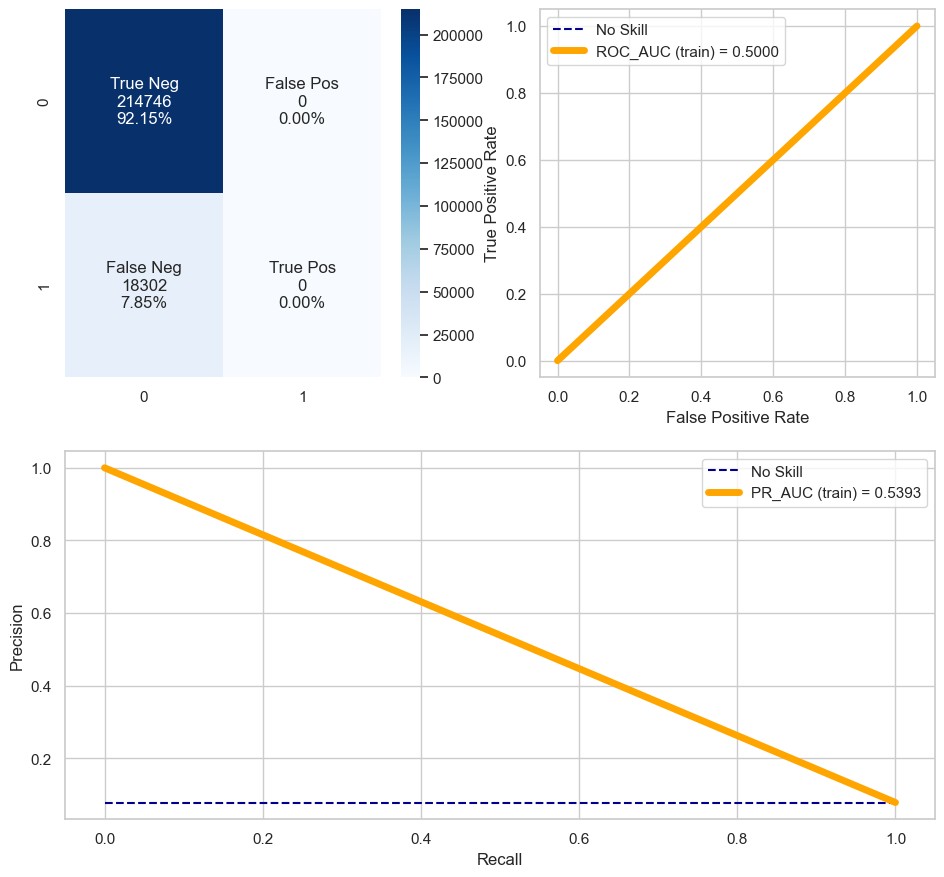

In [66]:
cf_matrix_roc_auc(dummy_clf, y_train, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

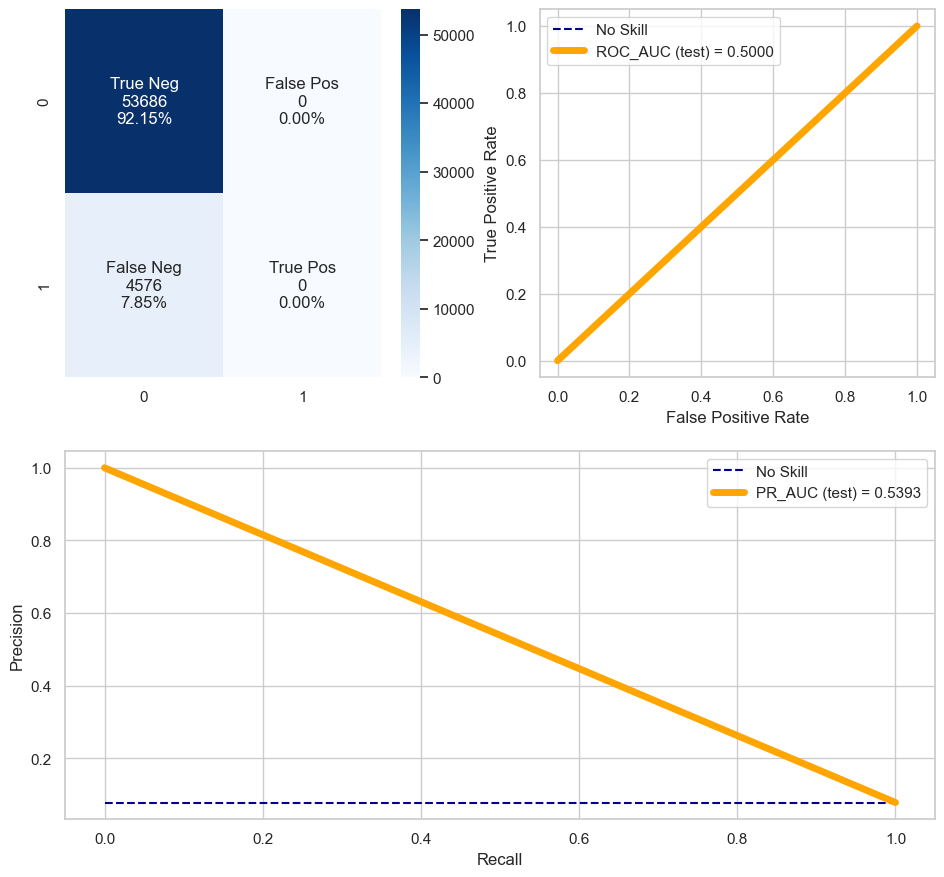

In [67]:
cf_matrix_roc_auc(dummy_clf, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores

In [68]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='Dummy'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='Dummy'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='Dummy'),'Time'] = round(end1-start1,4)

In [69]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='Dummy'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='Dummy'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='Dummy'),'Time'] = round(end2-start2,4)

In [70]:
# On conserve ces résultats pour un graphique comparatif
Dummy_y_pred1, Dummy_y_pred_proba1, Dummy_y_pred2, Dummy_y_pred_proba2, Dummy_roc_auc1, Dummy_roc_auc2 =\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [71]:
model_scores #Weight SAMPLE (hyperparamètre dans l'entrainement): concentration du même % -> plus concentration  de 1 
#balance accuracy=

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.7853,0.0285,0.5,
1,Test,Dummy,0.7854,0.0698,0.5,
2,Train,LogReg,,,,
3,Test,LogReg,,,,
4,Train,RandFor,,,,
5,Test,RandFor,,,,
6,Train,CatBoost,,,,
7,Test,CatBoost,,,,
8,Train,XGBC,,,,
9,Test,XGBC,,,,


## | Logistic Regression

tester l'ensemble de données

In [72]:
X_train.isna().sum()

CODE_GENDER                       0
AMT_CREDIT                        0
AMT_GOODS_PRICE                   0
REGION_POPULATION_RELATIVE        0
DAYS_BIRTH                        0
                                 ..
POS_MONTHS_BALANCE_SIZE           0
POS_COUNT                         0
INSTAL_DBD_SUM                    0
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    0
INSTAL_DAYS_ENTRY_PAYMENT_SUM     0
Length: 114, dtype: int64

In [73]:
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
import time

# Étape 2 : Appliquer SMOTE sur l'échantillon
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Créer le pipeline
pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('classifier', LogisticRegression(random_state=42))
])

C = [0.001, 0.01, 0.1, 1, 10]
penalty = ['l1', 'l2']


param_grid = {'classifier__C': C,
              'classifier__penalty': penalty}

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=-1)


# Effectuer la GridSearch avec une validation croisée de 3 plis
start_time = time.time()
grid.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

# Afficher les meilleurs paramètres, le meilleur score et le temps d'exécution
print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur score :", grid.best_score_)
print(f"Temps d'exécution: {end_time - start_time:.2f} secondes")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres : {'classifier__C': 10, 'classifier__penalty': 'l2'}
Meilleur score : -2.766950257513528
Temps d'exécution: 95.64 secondes


In [74]:
X_train_resampled.head(2)

,CODE_GENDER,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ELEVATORS_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,ELEVATORS_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,ELEVATORS_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Secondary_secondaryspecial,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Laborers,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_blockofflats,WALLSMATERIAL_MODE_Panel,DAYS_EMPLOYED_PERC,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MEAN,PREV_APP_CREDIT_PERC_MEAN,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_NAME_CONTRACT_TYPE_Consumerloans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_XNA_MEAN,PREV_NAME_PORTFOLIO_Cards_MEAN,PREV_NAME_PORTFOLIO_POS_MEAN,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_CHANNEL_TYPE_APCashloan_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_PRODUCT_COMBINATION_CardStreet_MEAN,PREV_PRODUCT_COMBINATION_CashStreethigh_MEAN,PREV_PRODUCT_COMBINATION_CashXSellhigh_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_PRODUCT_COMBINATION_POSindustrywithinterest_MEAN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MEAN,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_COUNT,INSTAL_DBD_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM
0,1.0,576000.0,576000.0,0.026392,-11664.0,-4251.0,-1735.0,-3960.0,1.0,2.0,2.0,0.0,0.0,0.646172,0.728577,0.576209,0.52,0.3333,0.4921,0.5236,0.3333,0.5128,0.52,0.3333,0.5010,0.3871,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.364455,-2897.0,-308.0,-1702.00,935173.000000,-2683.0,30935.0,2202.636364,-786.000,0.363636,0.636364,0.272727,0.0,-1175.0,-308.0,-657.5,140517.666667,1346.0,-2897.0,-2298.857143,-1224.285714,5089.995,10959.3450,0.804168,11.0,18.0,14.5,0.130706,0.033155,-2713.0,-1868.25,0.375,0.125,0.625,0.375,0.75,0.25,0.375,0.0,0.0,0.625,0.125,0.0,0.625,0.125,0.375,0.375,0.125,0.125,0.125,0.75,0.00,0.0,0.125,0.0,0.125,22500.000,13511.8170,402750.0,134690.400,1.136382,402750.0,168363.000,14.6,0.130706,-2713.0,-1733.2,-69.166667,36.0,36.0,239.0,-2061.147059,-70079.0
1,0.0,1125000.0,1125000.0,0.026392,-14199.0,-6624.0,-1095.0,-4959.0,1.0,2.0,2.0,0.0,0.0,0.505998,0.625012,0.634706,0.00,0.1667,0.0451,0.0000,0.1667,0.

### | Model & Gridsearch params definition

tester sur un échantillon

In [75]:
len(y_test)

58262

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import time

# Étape 1 : Créer un échantillon du jeux d'entrainement
sample_size = 10000
X_train_resample = X_train.sample(n=sample_size, random_state=42)
y_train_resample = y_train.loc[X_train_resample.index]

# Étape 1 : Créer un échantillon du jeux de test
X_test_resample = X_test.sample(n=sample_size, random_state=42)
y_test_resample = y_test.loc[X_test_resample.index]

# Étape 2 : Appliquer SMOTE sur l'échantillon
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resample, y_train_resample)

# Étape 3 : Créer le pipeline du modèle
pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)

# Étape 5 : Créer l'objet de recherche de grille
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Étape 6 : Ajuster la recherche de grille
start1 = time.time()
grid.fit(X_train_resampled, y_train_resampled)
end1 = time.time()

# Évaluation finale sur le jeu de données de test
y_pred = grid.best_estimator_.predict(X_test_resample)
test_accuracy = accuracy_score(y_test_resample, y_pred)

print(test_accuracy)

0.7019


### | Fit / Train

In [77]:
X_train.isna().sum()


CODE_GENDER                       0
AMT_CREDIT                        0
AMT_GOODS_PRICE                   0
REGION_POPULATION_RELATIVE        0
DAYS_BIRTH                        0
                                 ..
POS_MONTHS_BALANCE_SIZE           0
POS_COUNT                         0
INSTAL_DBD_SUM                    0
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    0
INSTAL_DAYS_ENTRY_PAYMENT_SUM     0
Length: 114, dtype: int64

In [78]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train)[:, 1]

# on n'utilise pas les prédictions du modèle mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train, y_pred1)

  2%|▏         | 2/100 [00:00<00:16,  5.86it/s]

0.0
0.010101010101010102


  4%|▍         | 4/100 [00:00<00:18,  5.21it/s]

0.020202020202020204
0.030303030303030304


  6%|▌         | 6/100 [00:01<00:17,  5.32it/s]

0.04040404040404041
0.05050505050505051


  8%|▊         | 8/100 [00:01<00:17,  5.40it/s]

0.06060606060606061
0.07070707070707072


  9%|▉         | 9/100 [00:01<00:16,  5.37it/s]

0.08080808080808081


 11%|█         | 11/100 [00:02<00:17,  5.17it/s]

0.09090909090909091
0.10101010101010102


 13%|█▎        | 13/100 [00:02<00:17,  5.03it/s]

0.11111111111111112
0.12121212121212122


 15%|█▌        | 15/100 [00:02<00:15,  5.41it/s]

0.13131313131313133
0.14141414141414144


 17%|█▋        | 17/100 [00:03<00:14,  5.68it/s]

0.15151515151515152
0.16161616161616163


 19%|█▉        | 19/100 [00:03<00:14,  5.76it/s]

0.17171717171717174
0.18181818181818182


 21%|██        | 21/100 [00:03<00:13,  5.96it/s]

0.19191919191919193
0.20202020202020204


 23%|██▎       | 23/100 [00:04<00:13,  5.81it/s]

0.21212121212121213
0.22222222222222224


 25%|██▌       | 25/100 [00:04<00:11,  6.25it/s]

0.23232323232323235
0.24242424242424243


 27%|██▋       | 27/100 [00:04<00:11,  6.22it/s]

0.25252525252525254
0.26262626262626265


 29%|██▉       | 29/100 [00:05<00:11,  6.09it/s]

0.27272727272727276
0.2828282828282829


 31%|███       | 31/100 [00:05<00:10,  6.40it/s]

0.29292929292929293
0.30303030303030304


 33%|███▎      | 33/100 [00:05<00:10,  6.12it/s]

0.31313131313131315
0.32323232323232326


 35%|███▌      | 35/100 [00:06<00:11,  5.78it/s]

0.33333333333333337
0.3434343434343435


 37%|███▋      | 37/100 [00:06<00:10,  6.23it/s]

0.3535353535353536
0.36363636363636365


 39%|███▉      | 39/100 [00:06<00:09,  6.26it/s]

0.37373737373737376
0.38383838383838387


 41%|████      | 41/100 [00:07<00:09,  6.45it/s]

0.393939393939394
0.4040404040404041


 43%|████▎     | 43/100 [00:07<00:09,  6.15it/s]

0.4141414141414142
0.42424242424242425


 45%|████▌     | 45/100 [00:07<00:08,  6.38it/s]

0.43434343434343436
0.4444444444444445


 47%|████▋     | 47/100 [00:08<00:08,  6.24it/s]

0.4545454545454546
0.4646464646464647


 49%|████▉     | 49/100 [00:08<00:07,  6.46it/s]

0.4747474747474748
0.48484848484848486


100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


In [79]:
confusion_matrix(y_train, y_pred1)

array([[148746,  66000],
       [  6390,  11912]], dtype=int64)

In [80]:
best_thresh

0.48484848484848486

In [81]:
best_custom_score

0.5573959012735574

In [82]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.7317
custom_score_train : 0.5574
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80    214746
         1.0       0.15      0.65      0.25     18302

    accuracy                           0.69    233048
   macro avg       0.56      0.67      0.53    233048
weighted avg       0.90      0.69      0.76    233048



### | Predict / Test

In [83]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

CPU times: total: 344 ms
Wall time: 327 ms


In [84]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.7347
custom_score_test : 0.5552
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.81     53686
         1.0       0.15      0.65      0.25      4576

    accuracy                           0.69     58262
   macro avg       0.56      0.67      0.53     58262
weighted avg       0.90      0.69      0.76     58262



### | AUC du fichier train “cross-validé” | choix meilleur modèle

In [85]:
# vérif calcul custom_score
FN=6597
FP=68759
indiv_train=246005
Verif_CS_LogReg = (FP+10*FN)/(10*indiv_train)

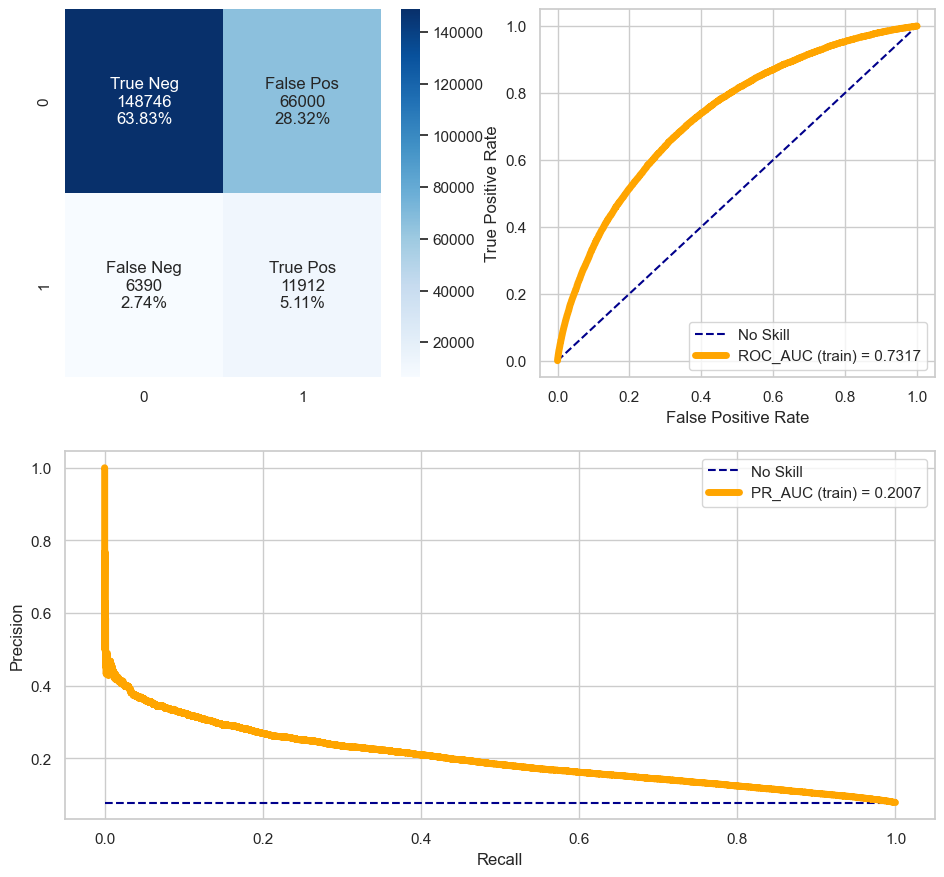

In [86]:
cf_matrix_roc_auc(grid, y_train, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

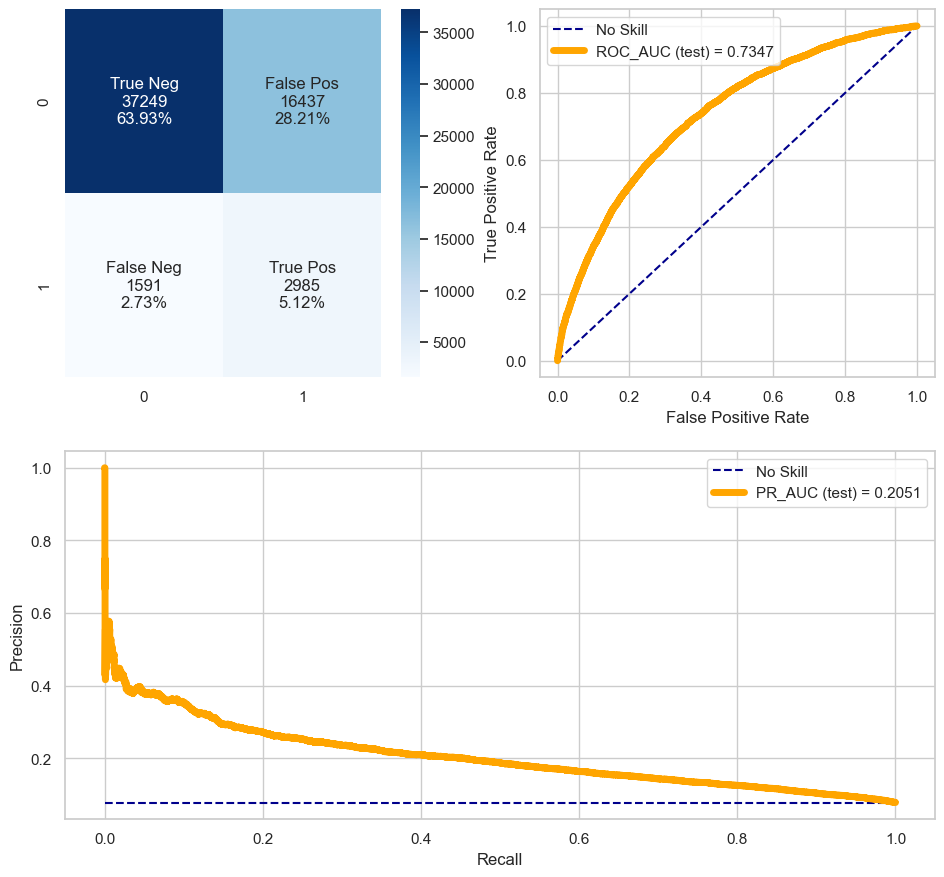

In [87]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores & backup best_estimator

In [88]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LogReg'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LogReg'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LogReg'),'Time'] = round(end1-start1,4)

In [89]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LogReg'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LogReg'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LogReg'),'Time'] = round(end2-start2,4)

In [90]:
# On conserve ces résultats pour un graphique comparatif
LogReg_y_pred1, LogReg_y_pred_proba1, LogReg_y_pred2, LogReg_y_pred_proba2, LogReg_roc_auc1, LogReg_roc_auc2 =\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [91]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.7853,0.0285,0.5,
1,Test,Dummy,0.7854,0.0698,0.5,
2,Train,LogReg,0.5574,7.6494,0.7317,
3,Test,LogReg,0.5552,0.3269,0.7347,
4,Train,RandFor,,,,
5,Test,RandFor,,,,
6,Train,CatBoost,,,,
7,Test,CatBoost,,,,
8,Train,XGBC,,,,
9,Test,XGBC,,,,


In [92]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()), ('scaler', StandardScaler()),
                ('classifier', LogisticRegression(C=100, random_state=42))])

In [93]:
joblib.dump(grid.best_estimator_, 'Models/best_model_LogReg.joblib')
# model = joblib.load('Models/best_model_LogReg.joblib') to load it back

['Models/best_model_LogReg.joblib']

In [94]:
joblib.dump(best_thresh, 'Models/best_thresh_LogReg.joblib')
# best_thresh = joblib.load('Models/best_thresh_LogReg.joblib') to load it back

['Models/best_thresh_LogReg.joblib']

## | Random Forest Classifier

### | Model & Gridsearch params definition

tester sur un échantillon

In [95]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import time

# Étape 1 : Créer un échantillon du dataframe
sample_size = 100000
X_train_resample = X_train.sample(n=sample_size, random_state=42)
y_train_resample = y_train.loc[X_train_resample.index]

# Étape 1 : Créer un échantillon du jeux de test
X_test_resample = X_test.sample(n=sample_size, random_state=42, replace='False')
y_test_resample = y_test.loc[X_test_resample.index]

# Étape 2 : Appliquer SMOTE sur l'échantillon
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resample, y_train_resample)

# Étape 3 : Créer le pipeline du modèle
pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Set hyperparamteters range

# number of trees in the random forest
n_estimators = [3, 4, 5, 6, 7] 
# number of features in consideration at every split
max_features = ['sqrt']
# minimum sample number that can be stored in a leaf node
# smaller leaves = model more prone to capturing noise in train data
min_samples_leaf = [45, 50, 55]

# Étape 4 : Définir la grille d'hyperparamètres
param_grid = {'classifier__n_estimators': n_estimators,
              'classifier__max_features': max_features,
              'classifier__min_samples_leaf': min_samples_leaf}

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)#tester sans grid search

# Étape 5 : Créer l'objet de recherche de grille
#grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)#n_jobs-->gpu

# Étape 6 : Ajuster la recherche de grille
start1 = time.time()
grid.fit(X_train_resampled, y_train_resampled)
end1 = time.time()

# Évaluation finale sur le jeu de données de test
y_pred = grid.best_estimator_.predict(X_test_resample)
test_accuracy = accuracy_score(y_test_resample, y_pred)

print(test_accuracy)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=3; total time=   3.1s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=3; total time=   2.9s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=3; total time=   2.8s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=4; total time=   3.7s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=4; total time=   3.7s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=4; total time=   3.7s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=5; total time=   4.4s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=5

    tester sur l'ensemble de dataset
    

In [96]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import time

# Étape 2 : Appliquer SMOTE sur l'échantillon
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV

pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('classifier', RandomForestClassifier(random_state=42))
])

max_depth = [5, 10, 15]
n_estimators = [5, 6, 7]
min_samples_split = [2, 5, 10]

param_grid = {'classifier__max_depth': max_depth,
              'classifier__n_estimators': n_estimators,
              'classifier__min_samples_split': min_samples_split}

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=-1)

# Entraînement et évaluation
grid.fit(X_train_resampled, y_train_resampled)

# Évaluation finale sur le jeu de données de test
y_pred = grid.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [97]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train_resampled)[:, 1]

# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train_resampled, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train_resampled, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train_resampled, y_pred1)

  1%|          | 1/100 [00:00<00:34,  2.91it/s]

0.0


  2%|▏         | 2/100 [00:00<00:30,  3.23it/s]

0.010101010101010102


  3%|▎         | 3/100 [00:00<00:28,  3.38it/s]

0.020202020202020204


  4%|▍         | 4/100 [00:01<00:27,  3.44it/s]

0.030303030303030304


  5%|▌         | 5/100 [00:01<00:28,  3.33it/s]

0.04040404040404041


  6%|▌         | 6/100 [00:01<00:27,  3.41it/s]

0.05050505050505051


  7%|▋         | 7/100 [00:02<00:27,  3.43it/s]

0.06060606060606061


  8%|▊         | 8/100 [00:02<00:26,  3.45it/s]

0.07070707070707072


  9%|▉         | 9/100 [00:02<00:26,  3.49it/s]

0.08080808080808081


 10%|█         | 10/100 [00:02<00:25,  3.47it/s]

0.09090909090909091


 11%|█         | 11/100 [00:03<00:25,  3.44it/s]

0.10101010101010102


 12%|█▏        | 12/100 [00:03<00:25,  3.44it/s]

0.11111111111111112


 13%|█▎        | 13/100 [00:03<00:25,  3.39it/s]

0.12121212121212122


 14%|█▍        | 14/100 [00:04<00:25,  3.37it/s]

0.13131313131313133


 15%|█▌        | 15/100 [00:04<00:25,  3.39it/s]

0.14141414141414144


 16%|█▌        | 16/100 [00:04<00:24,  3.41it/s]

0.15151515151515152


 17%|█▋        | 17/100 [00:04<00:24,  3.43it/s]

0.16161616161616163


 18%|█▊        | 18/100 [00:05<00:23,  3.50it/s]

0.17171717171717174


 19%|█▉        | 19/100 [00:05<00:23,  3.48it/s]

0.18181818181818182


 20%|██        | 20/100 [00:05<00:22,  3.51it/s]

0.19191919191919193


 21%|██        | 21/100 [00:06<00:22,  3.53it/s]

0.20202020202020204


 22%|██▏       | 22/100 [00:06<00:21,  3.55it/s]

0.21212121212121213


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


In [98]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train_resampled, y_pred1))

AUC_train : 0.9853
custom_score_train : 0.2220
              precision    recall  f1-score   support

         0.0       0.97      0.78      0.86    214746
         1.0       0.82      0.98      0.89    214746

    accuracy                           0.88    429492
   macro avg       0.89      0.88      0.88    429492
weighted avg       0.89      0.88      0.88    429492



### | Predict / Test

In [99]:
%%time
start2 = time.time()
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

CPU times: total: 312 ms
Wall time: 315 ms


In [100]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.6719
custom_score_test : 0.6279
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.83     53686
         1.0       0.14      0.52      0.22      4576

    accuracy                           0.71     58262
   macro avg       0.54      0.62      0.52     58262
weighted avg       0.88      0.71      0.78     58262



### | AUC du fichier train “cross-validé” | choix meilleur modèle

In [101]:
# vérif calcul custom_score
FN=17835
FP=4276
indiv_train=246005
Verif_CS_RandFor = (FP+10*FN)/(10*indiv_train)

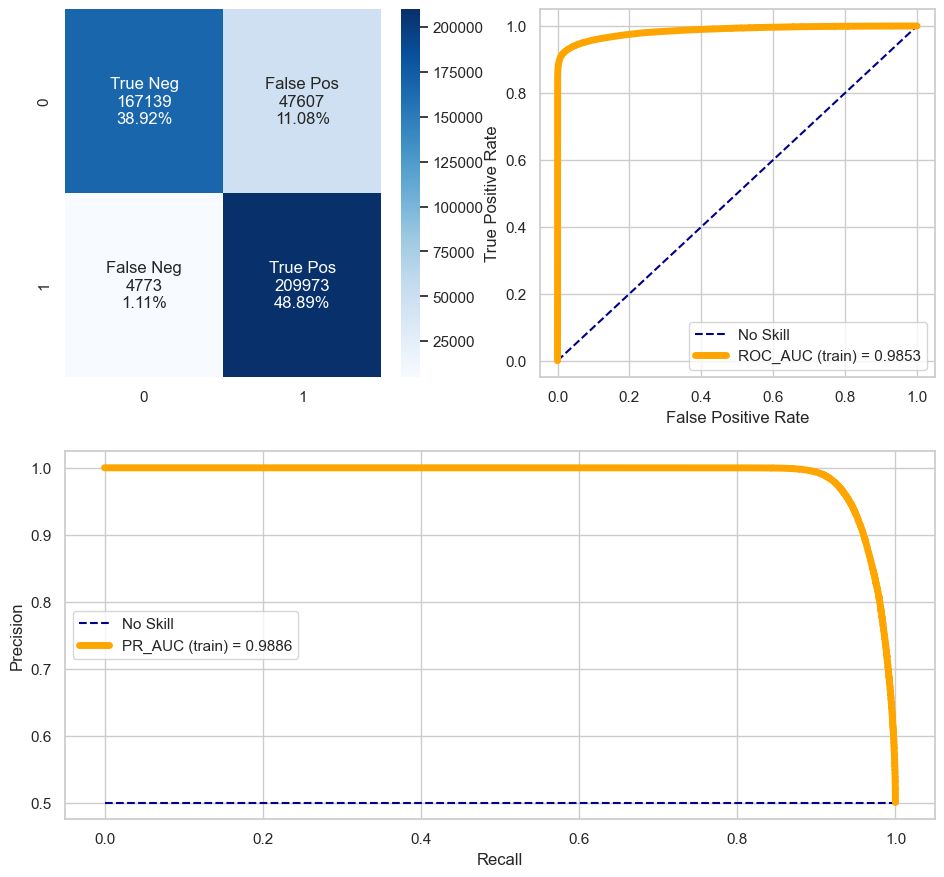

In [102]:
cf_matrix_roc_auc(grid, y_train_resampled, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

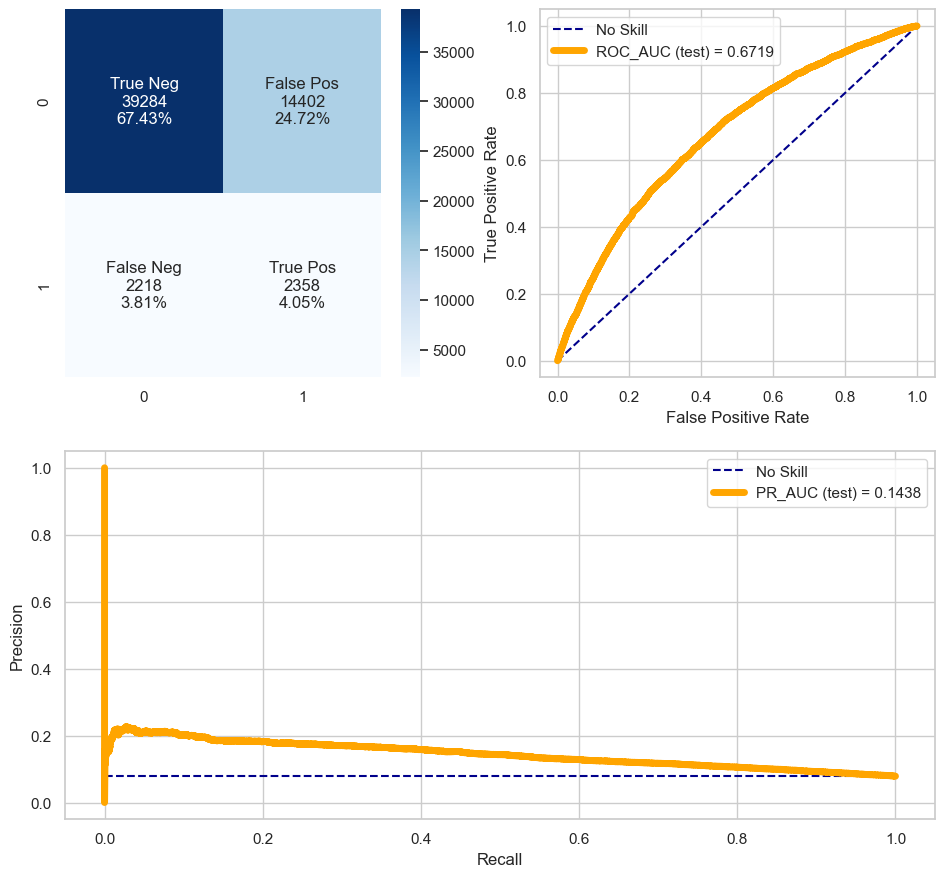

In [103]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores & backup best_estimator

In [104]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='RandFor'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='RandFor'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='RandFor'),'Time'] = round(end1-start1,4)

In [105]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='RandFor'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='RandFor'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='RandFor'),'Time'] = round(end2-start2,4)

In [106]:
# On conserve ces résultats pour un graphique comparatif
RandFor_y_pred1, RandFor_y_pred_proba1, RandFor_y_pred2, RandFor_y_pred_proba2, RandFor_roc_auc1, RandFor_roc_auc2=\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [107]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.7853,0.0285,0.5,
1,Test,Dummy,0.7854,0.0698,0.5,
2,Train,LogReg,0.5574,7.6494,0.7317,
3,Test,LogReg,0.5552,0.3269,0.7347,
4,Train,RandFor,0.222,229.8303,0.9853,
5,Test,RandFor,0.6279,0.3147,0.6719,
6,Train,CatBoost,,,,
7,Test,CatBoost,,,,
8,Train,XGBC,,,,
9,Test,XGBC,,,,


In [108]:
joblib.dump(grid.best_estimator_, 'Models/best_model_RandFor.joblib')
# model = joblib.load('Models/best_model_RandFor.joblib') to load it back

['Models/best_model_RandFor.joblib']

In [109]:
joblib.dump(best_thresh, 'Models/best_thresh_RandFor.joblib')
# best_thresh = joblib.load('Models/best_thresh_RandFor.joblib') to load it back

['Models/best_thresh_RandFor.joblib']

## | Cat Boost Classifier

### | Model & Gridsearch params definition

tester sur un échantillon

In [111]:
from catboost import CatBoostRegressor

# Étape 1 : Créer un échantillon du jeux d'entrainement
sample_size = 10000
X_train_resample = X_train.sample(n=sample_size, random_state=42)
y_train_resample = y_train.loc[X_train_resample.index]

# Étape 1 : Créer un échantillon du jeux de test
X_test_resample = X_test.sample(n=sample_size, random_state=42)
y_test_resample = y_test.loc[X_test_resample.index]

# Étape 2 : Appliquer SMOTE sur l'échantillon
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resample, y_train_resample)

# Étape 3 : Créer le pipeline du modèle
pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', CatBoostRegressor(random_state=42))
])


# Set hyperparamteters range

max_depth = [3, 4, 6]
n_estimators = [100, 200, 300]

param_grid = {'classifier__max_depth': max_depth,
              'classifier__n_estimators': n_estimators}

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)


# Étape 6 : Ajuster la recherche de grille
start1 = time.time()
grid.fit(X_train_resampled, y_train_resampled)
end1 = time.time()

# Évaluation finale sur le jeu de données de test
y_pred = grid.best_estimator_.predict(X_test_resample)
#test_accuracy = accuracy_score(y_test_resample, y_pred)

print(test_accuracy)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Learning rate set to 0.39562
0:	learn: 0.4420139	total: 13.4ms	remaining: 1.32s
1:	learn: 0.4051042	total: 24.7ms	remaining: 1.21s
2:	learn: 0.3700004	total: 37.4ms	remaining: 1.21s
3:	learn: 0.3511584	total: 48.8ms	remaining: 1.17s
4:	learn: 0.3395674	total: 60.8ms	remaining: 1.15s
5:	learn: 0.3250782	total: 72ms	remaining: 1.13s
6:	learn: 0.3121628	total: 83.6ms	remaining: 1.11s
7:	learn: 0.3037959	total: 92.7ms	remaining: 1.06s
8:	learn: 0.2991709	total: 100ms	remaining: 1.02s
9:	learn: 0.2949801	total: 109ms	remaining: 977ms
10:	learn: 0.2922935	total: 117ms	remaining: 945ms
11:	learn: 0.2875207	total: 125ms	remaining: 913ms
12:	learn: 0.2858066	total: 133ms	remaining: 889ms
13:	learn: 0.2836897	total: 141ms	remaining: 864ms
14:	learn: 0.2816913	total: 149ms	remaining: 842ms
15:	learn: 0.2804676	total: 156ms	remaining: 821ms
16:	learn: 0.2795047	total: 164ms	remaining: 802ms
17:	learn: 0.2778035	total: 172ms	remaining: 785

70:	learn: 0.2382479	total: 602ms	remaining: 246ms
71:	learn: 0.2376250	total: 612ms	remaining: 238ms
72:	learn: 0.2372842	total: 620ms	remaining: 229ms
73:	learn: 0.2369775	total: 628ms	remaining: 220ms
74:	learn: 0.2365748	total: 636ms	remaining: 212ms
75:	learn: 0.2362045	total: 644ms	remaining: 203ms
76:	learn: 0.2358623	total: 652ms	remaining: 195ms
77:	learn: 0.2354398	total: 660ms	remaining: 186ms
78:	learn: 0.2350169	total: 669ms	remaining: 178ms
79:	learn: 0.2345431	total: 677ms	remaining: 169ms
80:	learn: 0.2341593	total: 685ms	remaining: 161ms
81:	learn: 0.2338113	total: 694ms	remaining: 152ms
82:	learn: 0.2334690	total: 702ms	remaining: 144ms
83:	learn: 0.2328824	total: 711ms	remaining: 135ms
84:	learn: 0.2324596	total: 719ms	remaining: 127ms
85:	learn: 0.2318916	total: 728ms	remaining: 119ms
86:	learn: 0.2313121	total: 736ms	remaining: 110ms
87:	learn: 0.2309185	total: 745ms	remaining: 102ms
88:	learn: 0.2306108	total: 752ms	remaining: 93ms
89:	learn: 0.2298605	total: 761m

47:	learn: 0.2584735	total: 408ms	remaining: 1.29s
48:	learn: 0.2579089	total: 417ms	remaining: 1.28s
49:	learn: 0.2570900	total: 425ms	remaining: 1.27s
50:	learn: 0.2567429	total: 433ms	remaining: 1.27s
51:	learn: 0.2560040	total: 441ms	remaining: 1.25s
52:	learn: 0.2557074	total: 449ms	remaining: 1.24s
53:	learn: 0.2553023	total: 456ms	remaining: 1.23s
54:	learn: 0.2550116	total: 465ms	remaining: 1.23s
55:	learn: 0.2543624	total: 474ms	remaining: 1.22s
56:	learn: 0.2537426	total: 482ms	remaining: 1.21s
57:	learn: 0.2534078	total: 490ms	remaining: 1.2s
58:	learn: 0.2530576	total: 498ms	remaining: 1.19s
59:	learn: 0.2526388	total: 506ms	remaining: 1.18s
60:	learn: 0.2522666	total: 513ms	remaining: 1.17s
61:	learn: 0.2519160	total: 521ms	remaining: 1.16s
62:	learn: 0.2512873	total: 530ms	remaining: 1.15s
63:	learn: 0.2507438	total: 538ms	remaining: 1.14s
64:	learn: 0.2501478	total: 546ms	remaining: 1.13s
65:	learn: 0.2497828	total: 554ms	remaining: 1.13s
66:	learn: 0.2494911	total: 562m

20:	learn: 0.2839154	total: 195ms	remaining: 1.66s
21:	learn: 0.2816045	total: 203ms	remaining: 1.64s
22:	learn: 0.2796622	total: 211ms	remaining: 1.62s
23:	learn: 0.2780062	total: 219ms	remaining: 1.6s
24:	learn: 0.2758495	total: 227ms	remaining: 1.59s
25:	learn: 0.2745962	total: 234ms	remaining: 1.57s
26:	learn: 0.2738191	total: 242ms	remaining: 1.55s
27:	learn: 0.2726334	total: 250ms	remaining: 1.54s
28:	learn: 0.2714687	total: 259ms	remaining: 1.52s
29:	learn: 0.2707891	total: 267ms	remaining: 1.51s
30:	learn: 0.2700745	total: 274ms	remaining: 1.5s
31:	learn: 0.2694913	total: 282ms	remaining: 1.48s
32:	learn: 0.2688889	total: 290ms	remaining: 1.47s
33:	learn: 0.2681758	total: 298ms	remaining: 1.46s
34:	learn: 0.2674408	total: 306ms	remaining: 1.44s
35:	learn: 0.2667734	total: 315ms	remaining: 1.43s
36:	learn: 0.2659287	total: 323ms	remaining: 1.42s
37:	learn: 0.2654422	total: 331ms	remaining: 1.41s
38:	learn: 0.2649934	total: 339ms	remaining: 1.4s
39:	learn: 0.2645051	total: 347ms	

197:	learn: 0.2193795	total: 1.64s	remaining: 16.5ms
198:	learn: 0.2192074	total: 1.64s	remaining: 8.26ms
199:	learn: 0.2190721	total: 1.65s	remaining: 0us
[CV] END classifier__max_depth=3, classifier__n_estimators=200; total time=   1.9s
Learning rate set to 0.225189
0:	learn: 0.4708975	total: 12.1ms	remaining: 2.42s
1:	learn: 0.4402163	total: 22.6ms	remaining: 2.24s
2:	learn: 0.4185795	total: 33.8ms	remaining: 2.22s
3:	learn: 0.3937252	total: 45ms	remaining: 2.2s
4:	learn: 0.3721464	total: 56ms	remaining: 2.18s
5:	learn: 0.3569820	total: 66.6ms	remaining: 2.15s
6:	learn: 0.3474714	total: 77.8ms	remaining: 2.15s
7:	learn: 0.3373655	total: 89.3ms	remaining: 2.14s
8:	learn: 0.3292347	total: 98.5ms	remaining: 2.09s
9:	learn: 0.3204097	total: 106ms	remaining: 2.02s
10:	learn: 0.3157152	total: 115ms	remaining: 1.98s
11:	learn: 0.3109535	total: 123ms	remaining: 1.93s
12:	learn: 0.3056652	total: 131ms	remaining: 1.88s
13:	learn: 0.2998863	total: 140ms	remaining: 1.85s
14:	learn: 0.2960776	to

171:	learn: 0.2203964	total: 1.42s	remaining: 231ms
172:	learn: 0.2202698	total: 1.43s	remaining: 223ms
173:	learn: 0.2201108	total: 1.44s	remaining: 215ms
174:	learn: 0.2198994	total: 1.44s	remaining: 206ms
175:	learn: 0.2197409	total: 1.45s	remaining: 198ms
176:	learn: 0.2196250	total: 1.46s	remaining: 190ms
177:	learn: 0.2195012	total: 1.47s	remaining: 181ms
178:	learn: 0.2192710	total: 1.48s	remaining: 173ms
179:	learn: 0.2191195	total: 1.48s	remaining: 165ms
180:	learn: 0.2189079	total: 1.49s	remaining: 157ms
181:	learn: 0.2186904	total: 1.5s	remaining: 148ms
182:	learn: 0.2184188	total: 1.51s	remaining: 140ms
183:	learn: 0.2182367	total: 1.52s	remaining: 132ms
184:	learn: 0.2181140	total: 1.53s	remaining: 124ms
185:	learn: 0.2177891	total: 1.53s	remaining: 116ms
186:	learn: 0.2176721	total: 1.54s	remaining: 107ms
187:	learn: 0.2175068	total: 1.55s	remaining: 99ms
188:	learn: 0.2173593	total: 1.56s	remaining: 90.7ms
189:	learn: 0.2172464	total: 1.57s	remaining: 82.4ms
190:	learn: 

145:	learn: 0.2394778	total: 1.22s	remaining: 1.29s
146:	learn: 0.2390475	total: 1.23s	remaining: 1.28s
147:	learn: 0.2388480	total: 1.24s	remaining: 1.27s
148:	learn: 0.2385869	total: 1.25s	remaining: 1.26s
149:	learn: 0.2384595	total: 1.25s	remaining: 1.25s
150:	learn: 0.2382729	total: 1.26s	remaining: 1.25s
151:	learn: 0.2380916	total: 1.27s	remaining: 1.24s
152:	learn: 0.2378860	total: 1.28s	remaining: 1.23s
153:	learn: 0.2377716	total: 1.29s	remaining: 1.22s
154:	learn: 0.2376085	total: 1.29s	remaining: 1.21s
155:	learn: 0.2373934	total: 1.3s	remaining: 1.2s
156:	learn: 0.2372483	total: 1.31s	remaining: 1.19s
157:	learn: 0.2370043	total: 1.32s	remaining: 1.18s
158:	learn: 0.2368348	total: 1.32s	remaining: 1.18s
159:	learn: 0.2366110	total: 1.33s	remaining: 1.17s
160:	learn: 0.2364724	total: 1.34s	remaining: 1.16s
161:	learn: 0.2363481	total: 1.35s	remaining: 1.15s
162:	learn: 0.2362000	total: 1.36s	remaining: 1.14s
163:	learn: 0.2360268	total: 1.36s	remaining: 1.13s
164:	learn: 0.

21:	learn: 0.2945942	total: 193ms	remaining: 2.43s
22:	learn: 0.2929758	total: 200ms	remaining: 2.41s
23:	learn: 0.2916811	total: 208ms	remaining: 2.39s
24:	learn: 0.2894497	total: 215ms	remaining: 2.37s
25:	learn: 0.2875835	total: 223ms	remaining: 2.35s
26:	learn: 0.2852051	total: 230ms	remaining: 2.33s
27:	learn: 0.2835778	total: 238ms	remaining: 2.31s
28:	learn: 0.2819421	total: 245ms	remaining: 2.29s
29:	learn: 0.2808418	total: 253ms	remaining: 2.27s
30:	learn: 0.2795846	total: 260ms	remaining: 2.26s
31:	learn: 0.2786546	total: 268ms	remaining: 2.24s
32:	learn: 0.2778266	total: 275ms	remaining: 2.23s
33:	learn: 0.2771008	total: 283ms	remaining: 2.21s
34:	learn: 0.2758363	total: 291ms	remaining: 2.2s
35:	learn: 0.2748304	total: 299ms	remaining: 2.19s
36:	learn: 0.2740855	total: 306ms	remaining: 2.17s
37:	learn: 0.2734227	total: 314ms	remaining: 2.17s
38:	learn: 0.2721707	total: 322ms	remaining: 2.16s
39:	learn: 0.2716255	total: 330ms	remaining: 2.15s
40:	learn: 0.2711183	total: 338m

206:	learn: 0.2280094	total: 1.63s	remaining: 734ms
207:	learn: 0.2278250	total: 1.64s	remaining: 726ms
208:	learn: 0.2277012	total: 1.65s	remaining: 718ms
209:	learn: 0.2275868	total: 1.66s	remaining: 710ms
210:	learn: 0.2274276	total: 1.66s	remaining: 702ms
211:	learn: 0.2272655	total: 1.67s	remaining: 694ms
212:	learn: 0.2270974	total: 1.68s	remaining: 686ms
213:	learn: 0.2269271	total: 1.69s	remaining: 678ms
214:	learn: 0.2268182	total: 1.69s	remaining: 670ms
215:	learn: 0.2266858	total: 1.7s	remaining: 662ms
216:	learn: 0.2264981	total: 1.71s	remaining: 654ms
217:	learn: 0.2263441	total: 1.72s	remaining: 646ms
218:	learn: 0.2261716	total: 1.72s	remaining: 638ms
219:	learn: 0.2260194	total: 1.73s	remaining: 630ms
220:	learn: 0.2258910	total: 1.74s	remaining: 622ms
221:	learn: 0.2257186	total: 1.75s	remaining: 614ms
222:	learn: 0.2255633	total: 1.75s	remaining: 606ms
223:	learn: 0.2253454	total: 1.76s	remaining: 598ms
224:	learn: 0.2252669	total: 1.77s	remaining: 590ms
225:	learn: 0

71:	learn: 0.2537799	total: 606ms	remaining: 1.92s
72:	learn: 0.2535065	total: 615ms	remaining: 1.91s
73:	learn: 0.2532067	total: 623ms	remaining: 1.9s
74:	learn: 0.2529154	total: 630ms	remaining: 1.89s
75:	learn: 0.2525870	total: 638ms	remaining: 1.88s
76:	learn: 0.2522460	total: 646ms	remaining: 1.87s
77:	learn: 0.2518200	total: 654ms	remaining: 1.86s
78:	learn: 0.2514675	total: 662ms	remaining: 1.85s
79:	learn: 0.2509452	total: 670ms	remaining: 1.84s
80:	learn: 0.2506805	total: 679ms	remaining: 1.83s
81:	learn: 0.2504277	total: 687ms	remaining: 1.83s
82:	learn: 0.2501114	total: 695ms	remaining: 1.82s
83:	learn: 0.2498294	total: 703ms	remaining: 1.81s
84:	learn: 0.2496294	total: 711ms	remaining: 1.8s
85:	learn: 0.2493576	total: 720ms	remaining: 1.79s
86:	learn: 0.2490622	total: 728ms	remaining: 1.78s
87:	learn: 0.2487909	total: 737ms	remaining: 1.77s
88:	learn: 0.2485278	total: 745ms	remaining: 1.77s
89:	learn: 0.2482654	total: 753ms	remaining: 1.76s
90:	learn: 0.2480526	total: 761ms

247:	learn: 0.2194428	total: 2.02s	remaining: 424ms
248:	learn: 0.2192454	total: 2.03s	remaining: 416ms
249:	learn: 0.2191302	total: 2.04s	remaining: 408ms
250:	learn: 0.2189488	total: 2.05s	remaining: 400ms
251:	learn: 0.2187963	total: 2.06s	remaining: 392ms
252:	learn: 0.2186442	total: 2.06s	remaining: 383ms
253:	learn: 0.2184885	total: 2.07s	remaining: 375ms
254:	learn: 0.2184001	total: 2.08s	remaining: 367ms
255:	learn: 0.2183158	total: 2.09s	remaining: 359ms
256:	learn: 0.2182056	total: 2.1s	remaining: 351ms
257:	learn: 0.2181147	total: 2.1s	remaining: 342ms
258:	learn: 0.2178597	total: 2.11s	remaining: 334ms
259:	learn: 0.2177258	total: 2.12s	remaining: 326ms
260:	learn: 0.2176243	total: 2.13s	remaining: 318ms
261:	learn: 0.2175558	total: 2.13s	remaining: 310ms
262:	learn: 0.2174218	total: 2.14s	remaining: 302ms
263:	learn: 0.2173617	total: 2.15s	remaining: 293ms
264:	learn: 0.2172830	total: 2.16s	remaining: 285ms
265:	learn: 0.2171394	total: 2.17s	remaining: 277ms
266:	learn: 0.

17:	learn: 0.2668205	total: 247ms	remaining: 1.13s
18:	learn: 0.2659468	total: 259ms	remaining: 1.1s
19:	learn: 0.2642241	total: 270ms	remaining: 1.08s
20:	learn: 0.2632518	total: 282ms	remaining: 1.06s
21:	learn: 0.2618901	total: 293ms	remaining: 1.04s
22:	learn: 0.2611391	total: 305ms	remaining: 1.02s
23:	learn: 0.2603929	total: 316ms	remaining: 1000ms
24:	learn: 0.2587457	total: 327ms	remaining: 981ms
25:	learn: 0.2576332	total: 339ms	remaining: 964ms
26:	learn: 0.2569920	total: 349ms	remaining: 944ms
27:	learn: 0.2560507	total: 361ms	remaining: 928ms
28:	learn: 0.2540975	total: 372ms	remaining: 912ms
29:	learn: 0.2532786	total: 384ms	remaining: 896ms
30:	learn: 0.2523181	total: 396ms	remaining: 881ms
31:	learn: 0.2514510	total: 407ms	remaining: 866ms
32:	learn: 0.2503493	total: 419ms	remaining: 851ms
33:	learn: 0.2486188	total: 431ms	remaining: 837ms
34:	learn: 0.2471820	total: 443ms	remaining: 822ms
35:	learn: 0.2465597	total: 456ms	remaining: 810ms
36:	learn: 0.2457664	total: 470

90:	learn: 0.2111804	total: 1.05s	remaining: 104ms
91:	learn: 0.2107585	total: 1.06s	remaining: 92.6ms
92:	learn: 0.2101839	total: 1.08s	remaining: 81ms
93:	learn: 0.2097437	total: 1.09s	remaining: 69.4ms
94:	learn: 0.2090696	total: 1.1s	remaining: 57.8ms
95:	learn: 0.2086784	total: 1.11s	remaining: 46.2ms
96:	learn: 0.2082904	total: 1.12s	remaining: 34.7ms
97:	learn: 0.2079278	total: 1.13s	remaining: 23.1ms
98:	learn: 0.2076817	total: 1.14s	remaining: 11.5ms
99:	learn: 0.2074080	total: 1.15s	remaining: 0us
[CV] END classifier__max_depth=4, classifier__n_estimators=100; total time=   1.3s
Learning rate set to 0.225186
0:	learn: 0.4600094	total: 17.3ms	remaining: 3.44s
1:	learn: 0.4314099	total: 31.6ms	remaining: 3.13s
2:	learn: 0.4044461	total: 42.6ms	remaining: 2.79s
3:	learn: 0.3798638	total: 54.7ms	remaining: 2.68s
4:	learn: 0.3636572	total: 66.5ms	remaining: 2.59s
5:	learn: 0.3507250	total: 77.5ms	remaining: 2.5s
6:	learn: 0.3368716	total: 88.9ms	remaining: 2.45s
7:	learn: 0.329045

164:	learn: 0.2088974	total: 1.89s	remaining: 401ms
165:	learn: 0.2086297	total: 1.9s	remaining: 389ms
166:	learn: 0.2083974	total: 1.91s	remaining: 378ms
167:	learn: 0.2081567	total: 1.92s	remaining: 367ms
168:	learn: 0.2079160	total: 1.94s	remaining: 355ms
169:	learn: 0.2077358	total: 1.95s	remaining: 344ms
170:	learn: 0.2075687	total: 1.96s	remaining: 332ms
171:	learn: 0.2073229	total: 1.97s	remaining: 321ms
172:	learn: 0.2070737	total: 1.98s	remaining: 309ms
173:	learn: 0.2069239	total: 1.99s	remaining: 298ms
174:	learn: 0.2066820	total: 2s	remaining: 286ms
175:	learn: 0.2063573	total: 2.01s	remaining: 275ms
176:	learn: 0.2061362	total: 2.02s	remaining: 263ms
177:	learn: 0.2059774	total: 2.04s	remaining: 252ms
178:	learn: 0.2056997	total: 2.05s	remaining: 240ms
179:	learn: 0.2054650	total: 2.06s	remaining: 229ms
180:	learn: 0.2052777	total: 2.07s	remaining: 217ms
181:	learn: 0.2050152	total: 2.08s	remaining: 206ms
182:	learn: 0.2047789	total: 2.09s	remaining: 194ms
183:	learn: 0.20

123:	learn: 0.2173321	total: 1.44s	remaining: 883ms
124:	learn: 0.2170167	total: 1.45s	remaining: 872ms
125:	learn: 0.2167489	total: 1.46s	remaining: 860ms
126:	learn: 0.2161995	total: 1.48s	remaining: 848ms
127:	learn: 0.2157950	total: 1.49s	remaining: 836ms
128:	learn: 0.2155504	total: 1.5s	remaining: 825ms
129:	learn: 0.2152513	total: 1.51s	remaining: 813ms
130:	learn: 0.2149023	total: 1.52s	remaining: 801ms
131:	learn: 0.2146320	total: 1.53s	remaining: 790ms
132:	learn: 0.2143338	total: 1.54s	remaining: 778ms
133:	learn: 0.2141581	total: 1.55s	remaining: 766ms
134:	learn: 0.2138925	total: 1.56s	remaining: 754ms
135:	learn: 0.2136902	total: 1.57s	remaining: 741ms
136:	learn: 0.2133510	total: 1.59s	remaining: 729ms
137:	learn: 0.2130419	total: 1.6s	remaining: 718ms
138:	learn: 0.2128364	total: 1.61s	remaining: 706ms
139:	learn: 0.2126522	total: 1.62s	remaining: 694ms
140:	learn: 0.2124583	total: 1.63s	remaining: 682ms
141:	learn: 0.2123484	total: 1.64s	remaining: 670ms
142:	learn: 0.

89:	learn: 0.2243027	total: 1.03s	remaining: 1.25s
90:	learn: 0.2239511	total: 1.04s	remaining: 1.24s
91:	learn: 0.2236895	total: 1.05s	remaining: 1.23s
92:	learn: 0.2234651	total: 1.06s	remaining: 1.22s
93:	learn: 0.2231718	total: 1.07s	remaining: 1.2s
94:	learn: 0.2229049	total: 1.08s	remaining: 1.19s
95:	learn: 0.2226595	total: 1.09s	remaining: 1.18s
96:	learn: 0.2223554	total: 1.1s	remaining: 1.17s
97:	learn: 0.2220112	total: 1.11s	remaining: 1.15s
98:	learn: 0.2216621	total: 1.12s	remaining: 1.14s
99:	learn: 0.2210533	total: 1.13s	remaining: 1.13s
100:	learn: 0.2206078	total: 1.14s	remaining: 1.12s
101:	learn: 0.2204370	total: 1.15s	remaining: 1.11s
102:	learn: 0.2201466	total: 1.16s	remaining: 1.09s
103:	learn: 0.2198628	total: 1.17s	remaining: 1.08s
104:	learn: 0.2194971	total: 1.18s	remaining: 1.07s
105:	learn: 0.2192394	total: 1.2s	remaining: 1.06s
106:	learn: 0.2188960	total: 1.21s	remaining: 1.05s
107:	learn: 0.2184706	total: 1.22s	remaining: 1.04s
108:	learn: 0.2183239	tota

56:	learn: 0.2502757	total: 654ms	remaining: 2.79s
57:	learn: 0.2498903	total: 664ms	remaining: 2.77s
58:	learn: 0.2494604	total: 675ms	remaining: 2.75s
59:	learn: 0.2491250	total: 686ms	remaining: 2.74s
60:	learn: 0.2486904	total: 695ms	remaining: 2.72s
61:	learn: 0.2483119	total: 707ms	remaining: 2.71s
62:	learn: 0.2478937	total: 718ms	remaining: 2.7s
63:	learn: 0.2475652	total: 729ms	remaining: 2.69s
64:	learn: 0.2470871	total: 740ms	remaining: 2.68s
65:	learn: 0.2466842	total: 752ms	remaining: 2.66s
66:	learn: 0.2461410	total: 762ms	remaining: 2.65s
67:	learn: 0.2457514	total: 772ms	remaining: 2.63s
68:	learn: 0.2454231	total: 783ms	remaining: 2.62s
69:	learn: 0.2450769	total: 794ms	remaining: 2.61s
70:	learn: 0.2447529	total: 806ms	remaining: 2.6s
71:	learn: 0.2444329	total: 817ms	remaining: 2.59s
72:	learn: 0.2439703	total: 828ms	remaining: 2.58s
73:	learn: 0.2436834	total: 839ms	remaining: 2.56s
74:	learn: 0.2433839	total: 850ms	remaining: 2.55s
75:	learn: 0.2429807	total: 863ms

222:	learn: 0.2066042	total: 2.52s	remaining: 870ms
223:	learn: 0.2063963	total: 2.53s	remaining: 858ms
224:	learn: 0.2062427	total: 2.55s	remaining: 850ms
225:	learn: 0.2060279	total: 2.56s	remaining: 839ms
226:	learn: 0.2058285	total: 2.57s	remaining: 827ms
227:	learn: 0.2056490	total: 2.58s	remaining: 816ms
228:	learn: 0.2053560	total: 2.6s	remaining: 805ms
229:	learn: 0.2051692	total: 2.61s	remaining: 793ms
230:	learn: 0.2047437	total: 2.62s	remaining: 782ms
231:	learn: 0.2046168	total: 2.63s	remaining: 771ms
232:	learn: 0.2044470	total: 2.64s	remaining: 759ms
233:	learn: 0.2043123	total: 2.65s	remaining: 748ms
234:	learn: 0.2041781	total: 2.66s	remaining: 736ms
235:	learn: 0.2040606	total: 2.67s	remaining: 725ms
236:	learn: 0.2039092	total: 2.68s	remaining: 713ms
237:	learn: 0.2037402	total: 2.69s	remaining: 702ms
238:	learn: 0.2035873	total: 2.71s	remaining: 691ms
239:	learn: 0.2034733	total: 2.72s	remaining: 679ms
240:	learn: 0.2032399	total: 2.73s	remaining: 668ms
241:	learn: 0

92:	learn: 0.2346931	total: 1.06s	remaining: 2.37s
93:	learn: 0.2344910	total: 1.07s	remaining: 2.35s
94:	learn: 0.2341184	total: 1.08s	remaining: 2.34s
95:	learn: 0.2337795	total: 1.09s	remaining: 2.33s
96:	learn: 0.2334361	total: 1.11s	remaining: 2.31s
97:	learn: 0.2331794	total: 1.12s	remaining: 2.3s
98:	learn: 0.2329082	total: 1.13s	remaining: 2.29s
99:	learn: 0.2326984	total: 1.14s	remaining: 2.28s
100:	learn: 0.2322874	total: 1.15s	remaining: 2.27s
101:	learn: 0.2319690	total: 1.16s	remaining: 2.26s
102:	learn: 0.2315407	total: 1.18s	remaining: 2.25s
103:	learn: 0.2313271	total: 1.19s	remaining: 2.23s
104:	learn: 0.2308758	total: 1.2s	remaining: 2.22s
105:	learn: 0.2302580	total: 1.21s	remaining: 2.21s
106:	learn: 0.2300218	total: 1.22s	remaining: 2.2s
107:	learn: 0.2297167	total: 1.23s	remaining: 2.19s
108:	learn: 0.2295195	total: 1.24s	remaining: 2.18s
109:	learn: 0.2292975	total: 1.25s	remaining: 2.17s
110:	learn: 0.2288971	total: 1.27s	remaining: 2.16s
111:	learn: 0.2282281	t

258:	learn: 0.1980624	total: 2.94s	remaining: 465ms
259:	learn: 0.1978648	total: 2.95s	remaining: 454ms
260:	learn: 0.1976969	total: 2.96s	remaining: 442ms
261:	learn: 0.1975452	total: 2.97s	remaining: 431ms
262:	learn: 0.1973688	total: 2.98s	remaining: 420ms
263:	learn: 0.1971842	total: 2.99s	remaining: 408ms
264:	learn: 0.1970114	total: 3s	remaining: 397ms
265:	learn: 0.1968940	total: 3.02s	remaining: 385ms
266:	learn: 0.1967254	total: 3.03s	remaining: 374ms
267:	learn: 0.1965704	total: 3.04s	remaining: 363ms
268:	learn: 0.1963992	total: 3.05s	remaining: 351ms
269:	learn: 0.1960832	total: 3.06s	remaining: 340ms
270:	learn: 0.1959226	total: 3.07s	remaining: 329ms
271:	learn: 0.1957983	total: 3.08s	remaining: 317ms
272:	learn: 0.1956279	total: 3.09s	remaining: 306ms
273:	learn: 0.1955048	total: 3.1s	remaining: 295ms
274:	learn: 0.1954008	total: 3.12s	remaining: 283ms
275:	learn: 0.1953227	total: 3.13s	remaining: 272ms
276:	learn: 0.1952287	total: 3.14s	remaining: 261ms
277:	learn: 0.19

125:	learn: 0.2243290	total: 1.47s	remaining: 2.03s
126:	learn: 0.2241327	total: 1.48s	remaining: 2.02s
127:	learn: 0.2239761	total: 1.49s	remaining: 2s
128:	learn: 0.2236373	total: 1.5s	remaining: 1.99s
129:	learn: 0.2234404	total: 1.51s	remaining: 1.98s
130:	learn: 0.2232593	total: 1.52s	remaining: 1.97s
131:	learn: 0.2231230	total: 1.54s	remaining: 1.96s
132:	learn: 0.2228706	total: 1.55s	remaining: 1.94s
133:	learn: 0.2225751	total: 1.56s	remaining: 1.93s
134:	learn: 0.2223452	total: 1.57s	remaining: 1.92s
135:	learn: 0.2221097	total: 1.58s	remaining: 1.91s
136:	learn: 0.2218878	total: 1.6s	remaining: 1.9s
137:	learn: 0.2217170	total: 1.61s	remaining: 1.89s
138:	learn: 0.2215114	total: 1.62s	remaining: 1.87s
139:	learn: 0.2210498	total: 1.63s	remaining: 1.86s
140:	learn: 0.2207778	total: 1.64s	remaining: 1.85s
141:	learn: 0.2204190	total: 1.65s	remaining: 1.84s
142:	learn: 0.2201586	total: 1.66s	remaining: 1.83s
143:	learn: 0.2199198	total: 1.68s	remaining: 1.81s
144:	learn: 0.2197

292:	learn: 0.1918242	total: 3.36s	remaining: 80.2ms
293:	learn: 0.1916416	total: 3.37s	remaining: 68.7ms
294:	learn: 0.1914647	total: 3.38s	remaining: 57.3ms
295:	learn: 0.1912716	total: 3.39s	remaining: 45.8ms
296:	learn: 0.1911090	total: 3.4s	remaining: 34.4ms
297:	learn: 0.1909909	total: 3.41s	remaining: 22.9ms
298:	learn: 0.1908773	total: 3.42s	remaining: 11.5ms
299:	learn: 0.1907238	total: 3.44s	remaining: 0us
[CV] END classifier__max_depth=4, classifier__n_estimators=300; total time=   3.7s
Learning rate set to 0.39562
0:	learn: 0.4100667	total: 40.2ms	remaining: 3.98s
1:	learn: 0.3470774	total: 75.7ms	remaining: 3.71s
2:	learn: 0.3150815	total: 105ms	remaining: 3.4s
3:	learn: 0.2954729	total: 132ms	remaining: 3.18s
4:	learn: 0.2842413	total: 159ms	remaining: 3.01s
5:	learn: 0.2772269	total: 184ms	remaining: 2.88s
6:	learn: 0.2645221	total: 210ms	remaining: 2.78s
7:	learn: 0.2610021	total: 237ms	remaining: 2.72s
8:	learn: 0.2585552	total: 263ms	remaining: 2.66s
9:	learn: 0.25478

49:	learn: 0.2067153	total: 1.3s	remaining: 1.3s
50:	learn: 0.2058943	total: 1.33s	remaining: 1.27s
51:	learn: 0.2050176	total: 1.35s	remaining: 1.25s
52:	learn: 0.2039979	total: 1.38s	remaining: 1.22s
53:	learn: 0.2029290	total: 1.4s	remaining: 1.2s
54:	learn: 0.2019500	total: 1.43s	remaining: 1.17s
55:	learn: 0.2010219	total: 1.46s	remaining: 1.14s
56:	learn: 0.2000469	total: 1.48s	remaining: 1.12s
57:	learn: 0.1993037	total: 1.51s	remaining: 1.09s
58:	learn: 0.1981200	total: 1.53s	remaining: 1.06s
59:	learn: 0.1976135	total: 1.56s	remaining: 1.04s
60:	learn: 0.1967701	total: 1.58s	remaining: 1.01s
61:	learn: 0.1958962	total: 1.61s	remaining: 988ms
62:	learn: 0.1953903	total: 1.64s	remaining: 961ms
63:	learn: 0.1946199	total: 1.66s	remaining: 936ms
64:	learn: 0.1930849	total: 1.69s	remaining: 910ms
65:	learn: 0.1923259	total: 1.72s	remaining: 885ms
66:	learn: 0.1916039	total: 1.74s	remaining: 859ms
67:	learn: 0.1909304	total: 1.77s	remaining: 832ms
68:	learn: 0.1902485	total: 1.79s	r

14:	learn: 0.2588443	total: 422ms	remaining: 5.21s
15:	learn: 0.2568888	total: 448ms	remaining: 5.15s
16:	learn: 0.2531846	total: 478ms	remaining: 5.14s
17:	learn: 0.2519073	total: 503ms	remaining: 5.09s
18:	learn: 0.2505571	total: 529ms	remaining: 5.04s
19:	learn: 0.2478308	total: 557ms	remaining: 5.01s
20:	learn: 0.2462137	total: 584ms	remaining: 4.98s
21:	learn: 0.2453091	total: 610ms	remaining: 4.93s
22:	learn: 0.2443048	total: 637ms	remaining: 4.9s
23:	learn: 0.2429105	total: 663ms	remaining: 4.86s
24:	learn: 0.2415930	total: 690ms	remaining: 4.83s
25:	learn: 0.2408445	total: 717ms	remaining: 4.8s
26:	learn: 0.2398550	total: 744ms	remaining: 4.76s
27:	learn: 0.2388634	total: 771ms	remaining: 4.74s
28:	learn: 0.2380783	total: 797ms	remaining: 4.7s
29:	learn: 0.2373522	total: 824ms	remaining: 4.67s
30:	learn: 0.2366184	total: 850ms	remaining: 4.63s
31:	learn: 0.2359389	total: 878ms	remaining: 4.61s
32:	learn: 0.2352985	total: 904ms	remaining: 4.58s
33:	learn: 0.2346614	total: 930ms	

177:	learn: 0.1661357	total: 4.68s	remaining: 579ms
178:	learn: 0.1656677	total: 4.71s	remaining: 552ms
179:	learn: 0.1653268	total: 4.74s	remaining: 526ms
180:	learn: 0.1649788	total: 4.76s	remaining: 500ms
181:	learn: 0.1646232	total: 4.79s	remaining: 473ms
182:	learn: 0.1642954	total: 4.81s	remaining: 447ms
183:	learn: 0.1639507	total: 4.84s	remaining: 421ms
184:	learn: 0.1636070	total: 4.86s	remaining: 394ms
185:	learn: 0.1634788	total: 4.89s	remaining: 368ms
186:	learn: 0.1632104	total: 4.91s	remaining: 342ms
187:	learn: 0.1629382	total: 4.94s	remaining: 315ms
188:	learn: 0.1625156	total: 4.97s	remaining: 289ms
189:	learn: 0.1623700	total: 4.99s	remaining: 263ms
190:	learn: 0.1620887	total: 5.02s	remaining: 236ms
191:	learn: 0.1617436	total: 5.04s	remaining: 210ms
192:	learn: 0.1614902	total: 5.07s	remaining: 184ms
193:	learn: 0.1610375	total: 5.1s	remaining: 158ms
194:	learn: 0.1607925	total: 5.12s	remaining: 131ms
195:	learn: 0.1604404	total: 5.15s	remaining: 105ms
196:	learn: 0

140:	learn: 0.1774734	total: 3.72s	remaining: 1.56s
141:	learn: 0.1771270	total: 3.75s	remaining: 1.53s
142:	learn: 0.1768093	total: 3.77s	remaining: 1.5s
143:	learn: 0.1765233	total: 3.8s	remaining: 1.48s
144:	learn: 0.1763256	total: 3.83s	remaining: 1.45s
145:	learn: 0.1760649	total: 3.85s	remaining: 1.42s
146:	learn: 0.1757984	total: 3.88s	remaining: 1.4s
147:	learn: 0.1756313	total: 3.9s	remaining: 1.37s
148:	learn: 0.1752489	total: 3.93s	remaining: 1.34s
149:	learn: 0.1749824	total: 3.96s	remaining: 1.32s
150:	learn: 0.1748078	total: 3.98s	remaining: 1.29s
151:	learn: 0.1745062	total: 4.01s	remaining: 1.27s
152:	learn: 0.1740402	total: 4.03s	remaining: 1.24s
153:	learn: 0.1737742	total: 4.06s	remaining: 1.21s
154:	learn: 0.1735004	total: 4.09s	remaining: 1.19s
155:	learn: 0.1730202	total: 4.11s	remaining: 1.16s
156:	learn: 0.1727217	total: 4.14s	remaining: 1.13s
157:	learn: 0.1721635	total: 4.16s	remaining: 1.11s
158:	learn: 0.1719078	total: 4.19s	remaining: 1.08s
159:	learn: 0.17

99:	learn: 0.1943168	total: 2.65s	remaining: 2.65s
100:	learn: 0.1934768	total: 2.67s	remaining: 2.62s
101:	learn: 0.1930875	total: 2.7s	remaining: 2.6s
102:	learn: 0.1925020	total: 2.73s	remaining: 2.57s
103:	learn: 0.1920082	total: 2.75s	remaining: 2.54s
104:	learn: 0.1916178	total: 2.78s	remaining: 2.51s
105:	learn: 0.1909991	total: 2.81s	remaining: 2.49s
106:	learn: 0.1906423	total: 2.83s	remaining: 2.46s
107:	learn: 0.1902411	total: 2.86s	remaining: 2.43s
108:	learn: 0.1895099	total: 2.88s	remaining: 2.41s
109:	learn: 0.1890171	total: 2.91s	remaining: 2.38s
110:	learn: 0.1884890	total: 2.94s	remaining: 2.35s
111:	learn: 0.1881319	total: 2.96s	remaining: 2.33s
112:	learn: 0.1877564	total: 2.99s	remaining: 2.3s
113:	learn: 0.1873809	total: 3.01s	remaining: 2.27s
114:	learn: 0.1871200	total: 3.04s	remaining: 2.25s
115:	learn: 0.1866692	total: 3.06s	remaining: 2.22s
116:	learn: 0.1862164	total: 3.09s	remaining: 2.19s
117:	learn: 0.1858710	total: 3.12s	remaining: 2.17s
118:	learn: 0.18

57:	learn: 0.2276641	total: 1.56s	remaining: 6.5s
58:	learn: 0.2270705	total: 1.6s	remaining: 6.53s
59:	learn: 0.2266402	total: 1.62s	remaining: 6.49s
60:	learn: 0.2259191	total: 1.65s	remaining: 6.46s
61:	learn: 0.2252045	total: 1.67s	remaining: 6.43s
62:	learn: 0.2247551	total: 1.7s	remaining: 6.4s
63:	learn: 0.2242321	total: 1.73s	remaining: 6.36s
64:	learn: 0.2237725	total: 1.75s	remaining: 6.33s
65:	learn: 0.2233511	total: 1.78s	remaining: 6.3s
66:	learn: 0.2228401	total: 1.8s	remaining: 6.28s
67:	learn: 0.2223824	total: 1.83s	remaining: 6.25s
68:	learn: 0.2219855	total: 1.86s	remaining: 6.22s
69:	learn: 0.2214410	total: 1.89s	remaining: 6.2s
70:	learn: 0.2209907	total: 1.91s	remaining: 6.17s
71:	learn: 0.2204718	total: 1.94s	remaining: 6.14s
72:	learn: 0.2200852	total: 1.97s	remaining: 6.11s
73:	learn: 0.2197159	total: 1.99s	remaining: 6.08s
74:	learn: 0.2192788	total: 2.02s	remaining: 6.05s
75:	learn: 0.2189063	total: 2.04s	remaining: 6.02s
76:	learn: 0.2184344	total: 2.07s	rema

220:	learn: 0.1691078	total: 5.83s	remaining: 2.08s
221:	learn: 0.1688772	total: 5.85s	remaining: 2.06s
222:	learn: 0.1684857	total: 5.88s	remaining: 2.03s
223:	learn: 0.1683033	total: 5.91s	remaining: 2s
224:	learn: 0.1680514	total: 5.93s	remaining: 1.98s
225:	learn: 0.1678103	total: 5.96s	remaining: 1.95s
226:	learn: 0.1674175	total: 5.98s	remaining: 1.92s
227:	learn: 0.1671953	total: 6.01s	remaining: 1.9s
228:	learn: 0.1669058	total: 6.04s	remaining: 1.87s
229:	learn: 0.1668004	total: 6.06s	remaining: 1.84s
230:	learn: 0.1666081	total: 6.09s	remaining: 1.82s
231:	learn: 0.1664642	total: 6.11s	remaining: 1.79s
232:	learn: 0.1661813	total: 6.14s	remaining: 1.76s
233:	learn: 0.1660045	total: 6.16s	remaining: 1.74s
234:	learn: 0.1656981	total: 6.19s	remaining: 1.71s
235:	learn: 0.1656123	total: 6.21s	remaining: 1.69s
236:	learn: 0.1654142	total: 6.24s	remaining: 1.66s
237:	learn: 0.1651751	total: 6.27s	remaining: 1.63s
238:	learn: 0.1649538	total: 6.29s	remaining: 1.61s
239:	learn: 0.16

84:	learn: 0.2129170	total: 2.25s	remaining: 5.69s
85:	learn: 0.2124241	total: 2.28s	remaining: 5.66s
86:	learn: 0.2120234	total: 2.3s	remaining: 5.64s
87:	learn: 0.2115166	total: 2.33s	remaining: 5.61s
88:	learn: 0.2111629	total: 2.35s	remaining: 5.58s
89:	learn: 0.2107807	total: 2.38s	remaining: 5.55s
90:	learn: 0.2103405	total: 2.4s	remaining: 5.52s
91:	learn: 0.2100524	total: 2.43s	remaining: 5.49s
92:	learn: 0.2096515	total: 2.45s	remaining: 5.46s
93:	learn: 0.2090511	total: 2.48s	remaining: 5.44s
94:	learn: 0.2087107	total: 2.51s	remaining: 5.41s
95:	learn: 0.2076485	total: 2.53s	remaining: 5.38s
96:	learn: 0.2071458	total: 2.56s	remaining: 5.35s
97:	learn: 0.2068493	total: 2.58s	remaining: 5.32s
98:	learn: 0.2064468	total: 2.61s	remaining: 5.29s
99:	learn: 0.2060265	total: 2.63s	remaining: 5.26s
100:	learn: 0.2057578	total: 2.66s	remaining: 5.24s
101:	learn: 0.2053775	total: 2.68s	remaining: 5.21s
102:	learn: 0.2048158	total: 2.71s	remaining: 5.18s
103:	learn: 0.2046035	total: 2

250:	learn: 0.1627755	total: 6.54s	remaining: 1.28s
251:	learn: 0.1624397	total: 6.57s	remaining: 1.25s
252:	learn: 0.1622355	total: 6.59s	remaining: 1.22s
253:	learn: 0.1619926	total: 6.62s	remaining: 1.2s
254:	learn: 0.1617108	total: 6.65s	remaining: 1.17s
255:	learn: 0.1615505	total: 6.67s	remaining: 1.15s
256:	learn: 0.1613504	total: 6.7s	remaining: 1.12s
257:	learn: 0.1610537	total: 6.72s	remaining: 1.09s
258:	learn: 0.1608017	total: 6.75s	remaining: 1.07s
259:	learn: 0.1605789	total: 6.78s	remaining: 1.04s
260:	learn: 0.1603891	total: 6.8s	remaining: 1.02s
261:	learn: 0.1601815	total: 6.83s	remaining: 991ms
262:	learn: 0.1599536	total: 6.86s	remaining: 965ms
263:	learn: 0.1596720	total: 6.88s	remaining: 939ms
264:	learn: 0.1595414	total: 6.91s	remaining: 913ms
265:	learn: 0.1593883	total: 6.93s	remaining: 886ms
266:	learn: 0.1592463	total: 6.96s	remaining: 860ms
267:	learn: 0.1589785	total: 6.99s	remaining: 834ms
268:	learn: 0.1587129	total: 7.01s	remaining: 808ms
269:	learn: 0.1

112:	learn: 0.1994906	total: 3s	remaining: 4.96s
113:	learn: 0.1990493	total: 3.02s	remaining: 4.93s
114:	learn: 0.1985348	total: 3.05s	remaining: 4.9s
115:	learn: 0.1983186	total: 3.07s	remaining: 4.88s
116:	learn: 0.1980770	total: 3.1s	remaining: 4.85s
117:	learn: 0.1977099	total: 3.12s	remaining: 4.82s
118:	learn: 0.1974436	total: 3.15s	remaining: 4.79s
119:	learn: 0.1971635	total: 3.17s	remaining: 4.76s
120:	learn: 0.1964762	total: 3.2s	remaining: 4.74s
121:	learn: 0.1961377	total: 3.23s	remaining: 4.71s
122:	learn: 0.1957285	total: 3.25s	remaining: 4.68s
123:	learn: 0.1954019	total: 3.28s	remaining: 4.66s
124:	learn: 0.1950398	total: 3.31s	remaining: 4.63s
125:	learn: 0.1946492	total: 3.33s	remaining: 4.6s
126:	learn: 0.1942543	total: 3.36s	remaining: 4.57s
127:	learn: 0.1935479	total: 3.38s	remaining: 4.55s
128:	learn: 0.1932196	total: 3.41s	remaining: 4.52s
129:	learn: 0.1929120	total: 3.44s	remaining: 4.49s
130:	learn: 0.1926377	total: 3.46s	remaining: 4.46s
131:	learn: 0.19232

271:	learn: 0.1565347	total: 7.15s	remaining: 736ms
272:	learn: 0.1563106	total: 7.18s	remaining: 710ms
273:	learn: 0.1560802	total: 7.21s	remaining: 684ms
274:	learn: 0.1559044	total: 7.23s	remaining: 657ms
275:	learn: 0.1556336	total: 7.26s	remaining: 631ms
276:	learn: 0.1555283	total: 7.28s	remaining: 605ms
277:	learn: 0.1554377	total: 7.31s	remaining: 578ms
278:	learn: 0.1551140	total: 7.33s	remaining: 552ms
279:	learn: 0.1549040	total: 7.36s	remaining: 526ms
280:	learn: 0.1547879	total: 7.39s	remaining: 499ms
281:	learn: 0.1546286	total: 7.41s	remaining: 473ms
282:	learn: 0.1543962	total: 7.44s	remaining: 447ms
283:	learn: 0.1541135	total: 7.46s	remaining: 421ms
284:	learn: 0.1539367	total: 7.49s	remaining: 394ms
285:	learn: 0.1535928	total: 7.52s	remaining: 368ms
286:	learn: 0.1534182	total: 7.54s	remaining: 342ms
287:	learn: 0.1532179	total: 7.57s	remaining: 315ms
288:	learn: 0.1529060	total: 7.6s	remaining: 289ms
289:	learn: 0.1526785	total: 7.62s	remaining: 263ms
290:	learn: 0

tester sur l'ensemble des données

In [114]:
from catboost import CatBoostRegressor

# Étape 2 : Appliquer SMOTE sur l'échantillon
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Étape 3 : Créer le pipeline du modèle
pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', CatBoostRegressor(random_state=42))
])

depth = [5, 7]
learning_rate = [0.01, 0.05]
#reg_lambda = [1e-3, 1e-2, 1e-1, 1, 2]
#colsample_bytree = [0.95, 0.97, 0.99] cet hyperparamètre a planté mon code 

param_grid = {'classifier__depth': depth,
              'classifier__learning_rate': learning_rate}
              #'classifier__reg_lambda': reg_lambda}
              #'classifier__colsample_bytree': colsample_bytree}

stratified_kfold = StratifiedKFold(n_splits=2,
                                   shuffle=True,
                                   random_state=42)

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=-1)

# Étape 6 : Ajuster la recherche de grille
start1 = time.time()
grid.fit(X_train_resampled, y_train_resampled)
end1 = time.time()

# Évaluation finale sur le jeu de données de test
y_pred = grid.best_estimator_.predict(X_test)
#test_accuracy = accuracy_score(y_test, y_pred)

#print(test_accuracy)#erreur ValueError: Classification metrics can't handle a mix of binary and continuous targets

Fitting 2 folds for each of 4 candidates, totalling 8 fits
0:	learn: 0.4973637	total: 154ms	remaining: 2m 33s
1:	learn: 0.4947269	total: 285ms	remaining: 2m 22s
2:	learn: 0.4921543	total: 416ms	remaining: 2m 18s
3:	learn: 0.4896236	total: 544ms	remaining: 2m 15s
4:	learn: 0.4871169	total: 681ms	remaining: 2m 15s
5:	learn: 0.4846162	total: 811ms	remaining: 2m 14s
6:	learn: 0.4821668	total: 943ms	remaining: 2m 13s
7:	learn: 0.4797591	total: 1.07s	remaining: 2m 12s
8:	learn: 0.4773224	total: 1.19s	remaining: 2m 11s
9:	learn: 0.4749205	total: 1.32s	remaining: 2m 11s
10:	learn: 0.4725500	total: 1.45s	remaining: 2m 10s
11:	learn: 0.4702581	total: 1.57s	remaining: 2m 9s
12:	learn: 0.4679656	total: 1.69s	remaining: 2m 8s
13:	learn: 0.4657223	total: 1.82s	remaining: 2m 8s
14:	learn: 0.4635158	total: 1.95s	remaining: 2m 7s
15:	learn: 0.4613571	total: 2.08s	remaining: 2m 8s
16:	learn: 0.4593150	total: 2.2s	remaining: 2m 7s
17:	learn: 0.4572070	total: 2.33s	remaining: 2m 6s
18:	learn: 0.4550630	to

159:	learn: 0.3098455	total: 19s	remaining: 1m 39s
160:	learn: 0.3094335	total: 19.1s	remaining: 1m 39s
161:	learn: 0.3089370	total: 19.3s	remaining: 1m 39s
162:	learn: 0.3085439	total: 19.4s	remaining: 1m 39s
163:	learn: 0.3080902	total: 19.5s	remaining: 1m 39s
164:	learn: 0.3074817	total: 19.6s	remaining: 1m 39s
165:	learn: 0.3069640	total: 19.7s	remaining: 1m 38s
166:	learn: 0.3064870	total: 19.8s	remaining: 1m 38s
167:	learn: 0.3059480	total: 19.9s	remaining: 1m 38s
168:	learn: 0.3054306	total: 20s	remaining: 1m 38s
169:	learn: 0.3049201	total: 20.1s	remaining: 1m 38s
170:	learn: 0.3044555	total: 20.2s	remaining: 1m 38s
171:	learn: 0.3040862	total: 20.4s	remaining: 1m 38s
172:	learn: 0.3035796	total: 20.5s	remaining: 1m 37s
173:	learn: 0.3031622	total: 20.6s	remaining: 1m 37s
174:	learn: 0.3027528	total: 20.7s	remaining: 1m 37s
175:	learn: 0.3022407	total: 20.8s	remaining: 1m 37s
176:	learn: 0.3017415	total: 20.9s	remaining: 1m 37s
177:	learn: 0.3014047	total: 21s	remaining: 1m 37s

315:	learn: 0.2644318	total: 36.4s	remaining: 1m 18s
316:	learn: 0.2642767	total: 36.5s	remaining: 1m 18s
317:	learn: 0.2641778	total: 36.6s	remaining: 1m 18s
318:	learn: 0.2640787	total: 36.7s	remaining: 1m 18s
319:	learn: 0.2639832	total: 36.8s	remaining: 1m 18s
320:	learn: 0.2638006	total: 36.9s	remaining: 1m 18s
321:	learn: 0.2636649	total: 37.1s	remaining: 1m 18s
322:	learn: 0.2635332	total: 37.2s	remaining: 1m 17s
323:	learn: 0.2633493	total: 37.3s	remaining: 1m 17s
324:	learn: 0.2631995	total: 37.4s	remaining: 1m 17s
325:	learn: 0.2631054	total: 37.5s	remaining: 1m 17s
326:	learn: 0.2629991	total: 37.7s	remaining: 1m 17s
327:	learn: 0.2628955	total: 37.8s	remaining: 1m 17s
328:	learn: 0.2627889	total: 37.9s	remaining: 1m 17s
329:	learn: 0.2626597	total: 38s	remaining: 1m 17s
330:	learn: 0.2625126	total: 38.1s	remaining: 1m 17s
331:	learn: 0.2623831	total: 38.2s	remaining: 1m 16s
332:	learn: 0.2622114	total: 38.3s	remaining: 1m 16s
333:	learn: 0.2620828	total: 38.4s	remaining: 1m

473:	learn: 0.2494673	total: 53.6s	remaining: 59.5s
474:	learn: 0.2494046	total: 53.7s	remaining: 59.3s
475:	learn: 0.2493288	total: 53.8s	remaining: 59.2s
476:	learn: 0.2492156	total: 53.9s	remaining: 59.1s
477:	learn: 0.2491418	total: 54s	remaining: 59s
478:	learn: 0.2490599	total: 54.2s	remaining: 58.9s
479:	learn: 0.2490228	total: 54.3s	remaining: 58.8s
480:	learn: 0.2489575	total: 54.4s	remaining: 58.7s
481:	learn: 0.2488941	total: 54.5s	remaining: 58.5s
482:	learn: 0.2488158	total: 54.6s	remaining: 58.4s
483:	learn: 0.2487402	total: 54.7s	remaining: 58.3s
484:	learn: 0.2487061	total: 54.8s	remaining: 58.2s
485:	learn: 0.2486666	total: 54.9s	remaining: 58.1s
486:	learn: 0.2485964	total: 55s	remaining: 58s
487:	learn: 0.2485312	total: 55.1s	remaining: 57.8s
488:	learn: 0.2484848	total: 55.2s	remaining: 57.7s
489:	learn: 0.2484479	total: 55.3s	remaining: 57.6s
490:	learn: 0.2484102	total: 55.4s	remaining: 57.5s
491:	learn: 0.2483664	total: 55.5s	remaining: 57.3s
492:	learn: 0.248324

633:	learn: 0.2422322	total: 1m 11s	remaining: 41.1s
634:	learn: 0.2422063	total: 1m 11s	remaining: 41s
635:	learn: 0.2421731	total: 1m 11s	remaining: 40.9s
636:	learn: 0.2421415	total: 1m 11s	remaining: 40.8s
637:	learn: 0.2421166	total: 1m 11s	remaining: 40.7s
638:	learn: 0.2420955	total: 1m 11s	remaining: 40.6s
639:	learn: 0.2420532	total: 1m 11s	remaining: 40.5s
640:	learn: 0.2420305	total: 1m 12s	remaining: 40.3s
641:	learn: 0.2419980	total: 1m 12s	remaining: 40.2s
642:	learn: 0.2419675	total: 1m 12s	remaining: 40.1s
643:	learn: 0.2419488	total: 1m 12s	remaining: 40s
644:	learn: 0.2419257	total: 1m 12s	remaining: 39.8s
645:	learn: 0.2418781	total: 1m 12s	remaining: 39.7s
646:	learn: 0.2418570	total: 1m 12s	remaining: 39.6s
647:	learn: 0.2418339	total: 1m 12s	remaining: 39.5s
648:	learn: 0.2418012	total: 1m 12s	remaining: 39.4s
649:	learn: 0.2417692	total: 1m 12s	remaining: 39.3s
650:	learn: 0.2417382	total: 1m 13s	remaining: 39.2s
651:	learn: 0.2417082	total: 1m 13s	remaining: 39.

790:	learn: 0.2383528	total: 1m 28s	remaining: 23.3s
791:	learn: 0.2383137	total: 1m 28s	remaining: 23.2s
792:	learn: 0.2383006	total: 1m 28s	remaining: 23s
793:	learn: 0.2382870	total: 1m 28s	remaining: 22.9s
794:	learn: 0.2382756	total: 1m 28s	remaining: 22.8s
795:	learn: 0.2382427	total: 1m 28s	remaining: 22.7s
796:	learn: 0.2382266	total: 1m 28s	remaining: 22.6s
797:	learn: 0.2382143	total: 1m 28s	remaining: 22.5s
798:	learn: 0.2382021	total: 1m 28s	remaining: 22.4s
799:	learn: 0.2381912	total: 1m 29s	remaining: 22.3s
800:	learn: 0.2381769	total: 1m 29s	remaining: 22.1s
801:	learn: 0.2381507	total: 1m 29s	remaining: 22s
802:	learn: 0.2381378	total: 1m 29s	remaining: 21.9s
803:	learn: 0.2381229	total: 1m 29s	remaining: 21.8s
804:	learn: 0.2381132	total: 1m 29s	remaining: 21.7s
805:	learn: 0.2381022	total: 1m 29s	remaining: 21.6s
806:	learn: 0.2380782	total: 1m 29s	remaining: 21.5s
807:	learn: 0.2380614	total: 1m 29s	remaining: 21.3s
808:	learn: 0.2380466	total: 1m 29s	remaining: 21.

947:	learn: 0.2356442	total: 1m 44s	remaining: 5.74s
948:	learn: 0.2356328	total: 1m 44s	remaining: 5.63s
949:	learn: 0.2356180	total: 1m 44s	remaining: 5.52s
950:	learn: 0.2355876	total: 1m 45s	remaining: 5.41s
951:	learn: 0.2355579	total: 1m 45s	remaining: 5.3s
952:	learn: 0.2355469	total: 1m 45s	remaining: 5.19s
953:	learn: 0.2355371	total: 1m 45s	remaining: 5.08s
954:	learn: 0.2355226	total: 1m 45s	remaining: 4.97s
955:	learn: 0.2355004	total: 1m 45s	remaining: 4.86s
956:	learn: 0.2354928	total: 1m 45s	remaining: 4.75s
957:	learn: 0.2354788	total: 1m 45s	remaining: 4.64s
958:	learn: 0.2354653	total: 1m 45s	remaining: 4.53s
959:	learn: 0.2354526	total: 1m 46s	remaining: 4.42s
960:	learn: 0.2354330	total: 1m 46s	remaining: 4.31s
961:	learn: 0.2354163	total: 1m 46s	remaining: 4.2s
962:	learn: 0.2353985	total: 1m 46s	remaining: 4.08s
963:	learn: 0.2353879	total: 1m 46s	remaining: 3.98s
964:	learn: 0.2353719	total: 1m 46s	remaining: 3.86s
965:	learn: 0.2353613	total: 1m 46s	remaining: 3

In [169]:
from sklearn.metrics import r2_score, mean_squared_error

# Évaluation finale sur le jeu de données de test
y_pred = grid.best_estimator_.predict(X_test)

# Calculer le coefficient de détermination (R-carré)
r2 = r2_score(y_test, y_pred)
print(f"R-carré : {r2:.2f}")

# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test, y_pred)
print(f"Erreur quadratique moyenne : {mse:.2f}")

R-carré : -0.16
Erreur quadratique moyenne : 0.08


In [170]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train_resampled)[:, 1]

# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train_resampled, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train_resampled, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train_resampled, y_pred1)

  1%|          | 1/100 [00:00<00:52,  1.90it/s]

0.0


  2%|▏         | 2/100 [00:01<00:50,  1.93it/s]

0.010101010101010102


  3%|▎         | 3/100 [00:01<00:50,  1.94it/s]

0.020202020202020204


  4%|▍         | 4/100 [00:02<00:49,  1.94it/s]

0.030303030303030304


  5%|▌         | 5/100 [00:02<00:51,  1.84it/s]

0.04040404040404041


  6%|▌         | 6/100 [00:03<00:54,  1.74it/s]

0.05050505050505051


  7%|▋         | 7/100 [00:03<00:55,  1.68it/s]

0.06060606060606061


  8%|▊         | 8/100 [00:04<00:56,  1.64it/s]

0.07070707070707072


  9%|▉         | 9/100 [00:05<00:55,  1.64it/s]

0.08080808080808081


 10%|█         | 10/100 [00:05<00:55,  1.62it/s]

0.09090909090909091


 11%|█         | 11/100 [00:06<00:55,  1.61it/s]

0.10101010101010102


 12%|█▏        | 12/100 [00:07<00:54,  1.60it/s]

0.11111111111111112


 13%|█▎        | 13/100 [00:07<00:53,  1.62it/s]

0.12121212121212122


 14%|█▍        | 14/100 [00:08<00:53,  1.62it/s]

0.13131313131313133


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


In [171]:
roc_auc1 = roc_auc_score(y_train_resampled, y_pred_proba1)

In [172]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train_resampled, y_pred1))

AUC_train : 0.9968
custom_score_train : 0.0968
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94    214746
         1.0       0.91      0.99      0.95    214746

    accuracy                           0.95    429492
   macro avg       0.95      0.95      0.95    429492
weighted avg       0.95      0.95      0.95    429492



### | Predict / Test

In [173]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

CPU times: total: 4.09 s
Wall time: 778 ms


In [174]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.7172
custom_score_test : 0.6013
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.90     53686
         1.0       0.19      0.41      0.26      4576

    accuracy                           0.82     58262
   macro avg       0.57      0.63      0.58     58262
weighted avg       0.88      0.82      0.85     58262



### | AUC du fichier train “cross-validé” | choix meilleur modèle

In [175]:
# vérif calcul custom_score
FN=17811
FP=435
indiv_train=246005
Verif_CS_CatBoost = (FP+10*FN)/(10*indiv_train)

In [182]:
cf_matrix_roc_auc(grid, y_train, y_pred1, y_pred_proba1, "train")#ValueError: Found input variables with inconsistent numbers of samples: [233048, 429492]

ValueError: Found input variables with inconsistent numbers of samples: [233048, 429492]

In [188]:
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def cf_matrix_roc_auc(estimator, y_true, y_pred, y_prob, dataset_name):
    """
    Fonction pour afficher la matrice de confusion et la courbe ROC-AUC.
    """
    # Calcul de la matrice de confusion
    cf_matrix = confusion_matrix(y_true, y_pred)
    
    # Calcul du score ROC-AUC
    roc_auc = roc_auc_score(y_true, y_prob)
    
    # Calcul du R2 et MSE
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    # Affichage des résultats
    print(f"Résultats sur le jeu de données {dataset_name}:")
    print(f"Score ROC-AUC: {roc_auc:.2f}")
    print(f"Coefficient de détermination (R2): {r2:.2f}")
    print(f"Erreur quadratique moyenne (MSE): {mse:.2f}")
    
    # Affichage de la matrice de confusion
    plt.figure(figsize=(8, 6))
    plt.imshow(cf_matrix, cmap='Blues')
    plt.title(f"Matrice de confusion sur {dataset_name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Réel")
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_true)))
    plt.xticks(tick_marks, np.unique(y_true))
    plt.yticks(tick_marks, np.unique(y_true))
    plt.show()
    
    # Affichage de la courbe ROC
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f"Courbe ROC sur {dataset_name}")
    plt.show()

In [206]:
print(len(y_train))
print(len(y_pred1))
y_pred1 = y_pred1[:len(y_train)]
y_pred_proba1 = y_pred_proba1[:len(y_train)]

233048
233048


In [207]:
print(len(y_pred1))
print(len(y_pred_proba1))

233048
233048


Résultats sur le jeu de données train:
Score ROC-AUC: 0.96
Coefficient de détermination (R2): -0.38
Erreur quadratique moyenne (MSE): 0.10


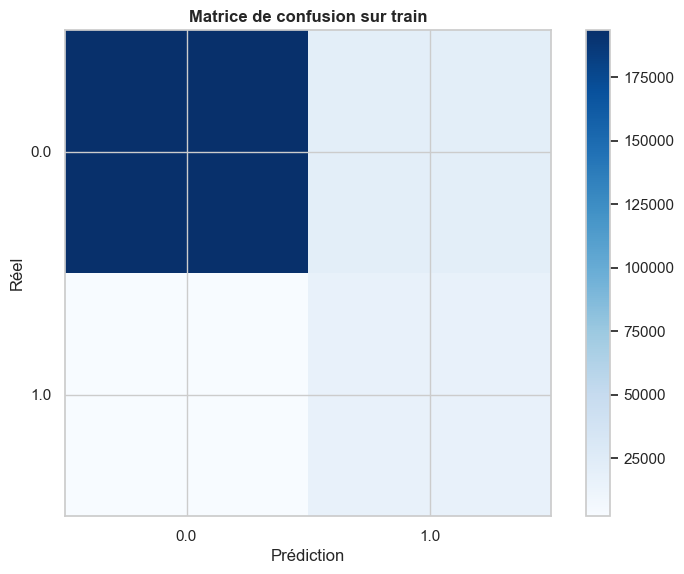

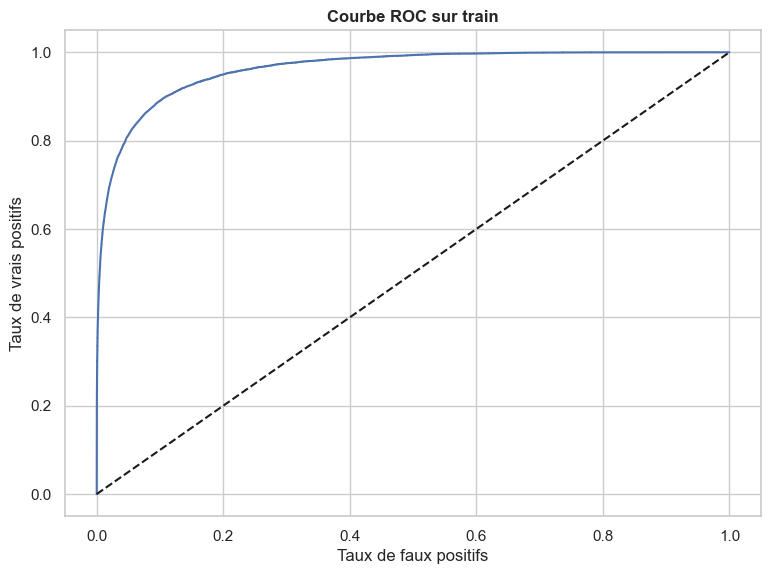

In [208]:
cf_matrix_roc_auc(grid, y_train, y_pred1, y_pred_proba1, "train")#ERREUR y_pred1, y_pred_proba1 et y__train n'ont pas la même taille

### | AUC du fichier test | contrôle de cohérence

Résultats sur le jeu de données test:
Score ROC-AUC: 0.72
Coefficient de détermination (R2): -1.52
Erreur quadratique moyenne (MSE): 0.18


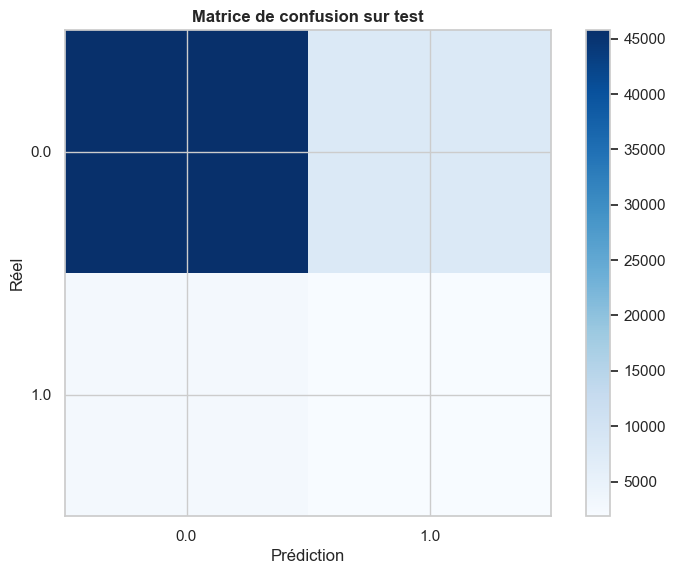

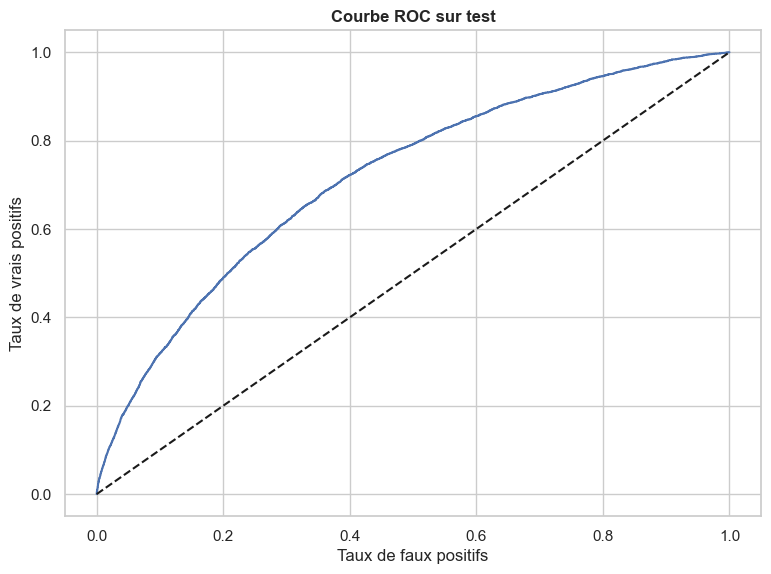

In [181]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores & backup best_estimator

In [209]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='CatBoost'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='CatBoost'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='CatBoost'),'Time'] = round(end1-start1,4)

In [210]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='CatBoost'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='CatBoost'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='CatBoost'),'Time'] = round(end2-start2,4)

In [211]:
# On conserve ces résultats pour un graphique comparatif
CatBoost_y_pred1, CatBoost_y_pred_proba1, CatBoost_y_pred2, CatBoost_y_pred_proba2, CatBoost_roc_auc1, CatBoost_roc_auc2=\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [212]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.7853,0.0285,0.5,
1,Test,Dummy,0.7854,0.0698,0.5,
2,Train,LogReg,0.5574,7.6494,0.7317,
3,Test,LogReg,0.5552,0.3269,0.7347,
4,Train,RandFor,0.222,229.8303,0.9853,
5,Test,RandFor,0.6279,0.3147,0.6719,
6,Train,CatBoost,0.0968,414.8919,0.9968,
7,Test,CatBoost,0.6013,0.7776,0.7172,
8,Train,XGBC,0.0968,414.8919,0.9968,
9,Test,XGBC,0.6013,0.7588,0.7172,


In [213]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [214]:
grid.best_params_

{'classifier__max_depth': 9, 'classifier__subsample': 0.5}

In [215]:
joblib.dump(grid.best_estimator_, 'Models/best_model_CatBoost.joblib')
# model = joblib.load('Models/best_model_CatBoost.joblib') to load it back

['Models/best_model_CatBoost.joblib']

In [216]:
joblib.dump(best_thresh, 'Models/best_thresh_CatBoost.joblib')
# best_thresh = joblib.load('Models/best_thresh_CatBoost.joblib') to load it back

['Models/best_thresh_CatBoost.joblib']

## | XGB Classifier

### | Model & Gridsearch params definition

tester un échantillon

In [ ]:
from xgboost import XGBClassifier

# Étape 1 : Créer un échantillon du jeux d'entrainement
sample_size = 10000
X_train_resample = X_train.sample(n=sample_size, random_state=42)
y_train_resample = y_train.loc[X_train_sample.index]

# Étape 1 : Créer un échantillon du jeux de test
X_test_resample = X_test.sample(n=sample_size, random_state=42)
y_test_resample = y_test.loc[X_test_resample.index]

# Étape 2 : Appliquer SMOTE sur l'échantillon
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resample, y_train_resample)

# Étape 3 : Créer le pipeline du modèle
pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(random_state=42))
])

# Set hyperparamteters range

# how quickly the model fits the residual errors
# by using additional base learners
learning_rate = [0.001, 0.01, 0.05, 0.1, 0.2]

# how deep the tree's decision nodes can go. 
# Must be a positive integer
max_depth = [2, 3, 5]

# fraction of the training set that can be used to train each tree.
# too low = underfitting / too high = overfitting
subsample = [0.5, 0.7, 0.9]

# fraction of the features that can be used to train each tree
colsample_bytree = [0.5, 0.95, 0.99]

param_grid = {'classifier__learning_rate': learning_rate,
              'classifier__max_depth': max_depth,
              'classifier__subsample': subsample,
              'classifier__colsample_bytree': colsample_bytree}

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)


# Étape 6 : Ajuster la recherche de grille
start1 = time.time()
grid.fit(X_train_resampled, y_train_resampled)
end1 = time.time()

# Évaluation finale sur le jeu de données de test
y_pred = grid.best_estimator_.predict(X_test_resample)
test_accuracy = accuracy_score(y_test_resample, y_pred)

print(test_accuracy)

tester sur l'ensemble

In [147]:
from xgboost import XGBClassifier

# Étape 1 : Créer un échantillon du jeux d'entrainement
sample_size = 10000
X_train_resample = X_train.sample(n=sample_size, random_state=42)
y_train_resample = y_train.loc[X_train_resample.index]

# Étape 1 : Créer un échantillon du jeux de test
X_test_resample = X_test.sample(n=sample_size, random_state=42)
y_test_resample = y_test.loc[X_test_resample.index]

# Étape 2 : Appliquer SMOTE sur l'échantillon
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Étape 3 : Créer le pipeline du modèle
pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(random_state=42))
])


max_depth = [5, 7, 9] #ça n'a n'a pa tourné avec estimators testés avec les valeurs suivantes ([100,200,300]/[3,5,7])
subsample = [0.5, 0.75, 0.9]
reg_lambda = [1e-3, 1e-2, 1e-1, 1, 2]
#colsample_bytree = [0.95, 0.97, 0.99] cet hyperparamètre a planté mon code 

param_grid = {'classifier__max_depth': max_depth,
              'classifier__subsample': subsample}
              #'classifier__reg_lambda': reg_lambda}
              #'classifier__colsample_bytree': colsample_bytree}

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=-1)

# Étape 6 : Ajuster la recherche de grille
start1 = time.time()
grid.fit(X_train_resampled, y_train_resampled)
end1 = time.time()

# Évaluation finale sur le jeu de données de test
y_pred = grid.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(test_accuracy)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
0.9159658096186193


In [148]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train_resampled)[:, 1]

# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train_resampled, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train_resampled, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train_resampled, y_pred1)

  1%|          | 1/100 [00:00<01:02,  1.57it/s]

0.0


  2%|▏         | 2/100 [00:01<01:03,  1.54it/s]

0.010101010101010102


  3%|▎         | 3/100 [00:01<01:01,  1.57it/s]

0.020202020202020204


  4%|▍         | 4/100 [00:02<01:01,  1.57it/s]

0.030303030303030304


  5%|▌         | 5/100 [00:03<00:59,  1.59it/s]

0.04040404040404041


  6%|▌         | 6/100 [00:03<00:58,  1.61it/s]

0.05050505050505051


  7%|▋         | 7/100 [00:04<00:58,  1.60it/s]

0.06060606060606061


  8%|▊         | 8/100 [00:05<00:57,  1.61it/s]

0.07070707070707072


  9%|▉         | 9/100 [00:05<00:55,  1.63it/s]

0.08080808080808081


 10%|█         | 10/100 [00:06<00:55,  1.62it/s]

0.09090909090909091


 11%|█         | 11/100 [00:06<00:55,  1.61it/s]

0.10101010101010102


 12%|█▏        | 12/100 [00:07<00:54,  1.62it/s]

0.11111111111111112


 13%|█▎        | 13/100 [00:08<00:54,  1.61it/s]

0.12121212121212122


 14%|█▍        | 14/100 [00:08<00:53,  1.62it/s]

0.13131313131313133


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


In [149]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train_resampled, y_pred1))

AUC_train : 0.9968
custom_score_train : 0.0968
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94    214746
         1.0       0.91      0.99      0.95    214746

    accuracy                           0.95    429492
   macro avg       0.95      0.95      0.95    429492
weighted avg       0.95      0.95      0.95    429492



### | Predict / Test

In [150]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

CPU times: total: 3.92 s
Wall time: 759 ms


In [151]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.7172
custom_score_test : 0.6013
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.90     53686
         1.0       0.19      0.41      0.26      4576

    accuracy                           0.82     58262
   macro avg       0.57      0.63      0.58     58262
weighted avg       0.88      0.82      0.85     58262



### | AUC du fichier train “cross-validé” | choix meilleur modèle

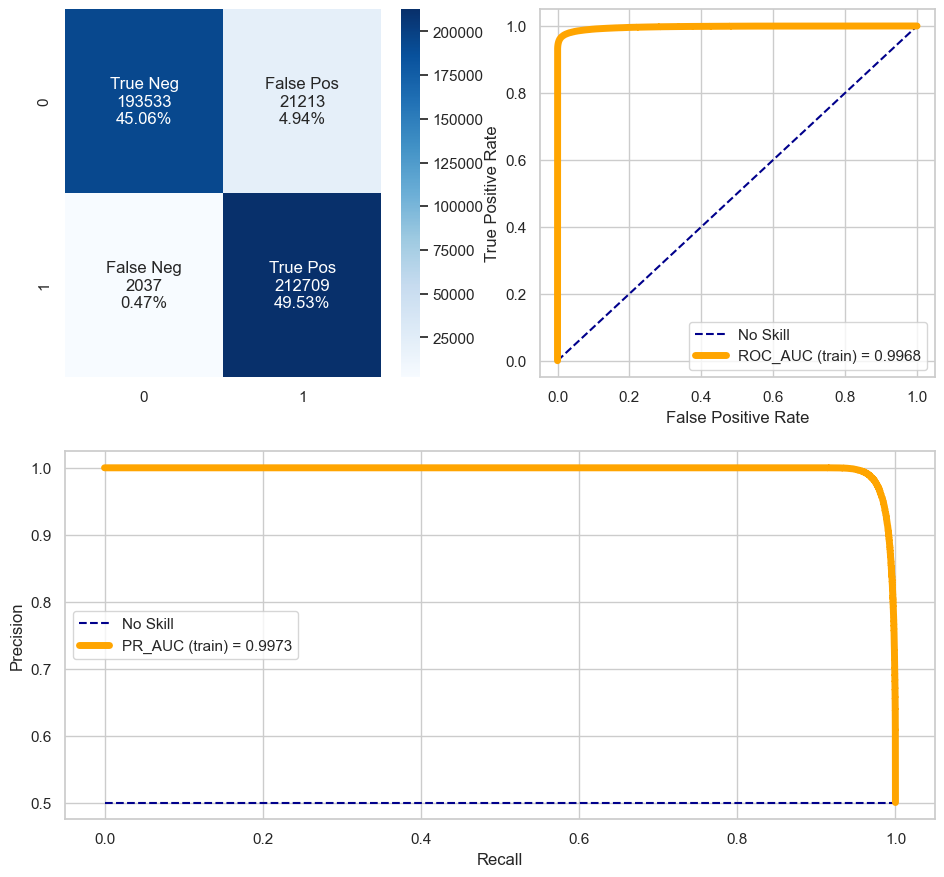

In [152]:
cf_matrix_roc_auc(grid, y_train_resampled, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

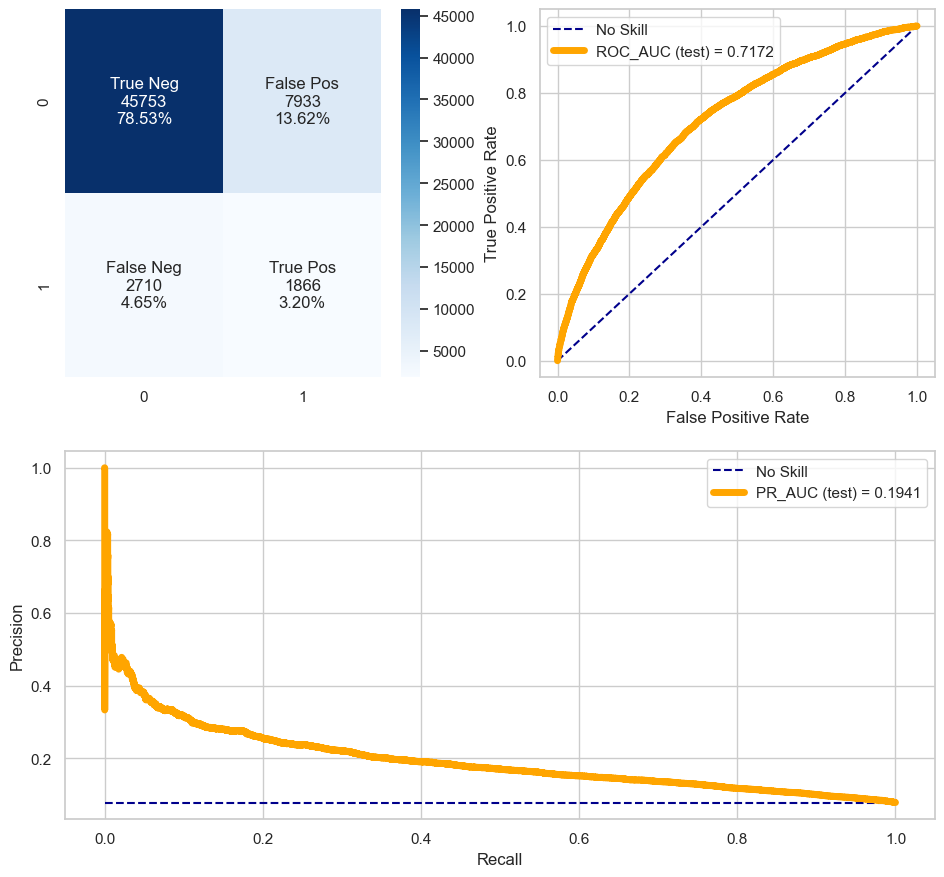

In [153]:
cf_matrix_roc_auc(grid, y_test,
                  y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores & backup best_estimator

In [154]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='XGBC'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='XGBC'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='XGBC'),'Time'] = round(end1-start1,4)

In [155]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='XGBC'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='XGBC'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='XGBC'),'Time'] = round(end2-start2,4)

In [156]:
# On conserve ces résultats pour un graphique comparatif
XGBC_y_pred1, XGBC_y_pred_proba1, XGBC_y_pred2, XGBC_y_pred_proba2, XGBC_roc_auc1, XGBC_roc_auc2=\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [157]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.7853,0.0285,0.5,
1,Test,Dummy,0.7854,0.0698,0.5,
2,Train,LogReg,0.5574,7.6494,0.7317,
3,Test,LogReg,0.5552,0.3269,0.7347,
4,Train,RandFor,0.222,229.8303,0.9853,
5,Test,RandFor,0.6279,0.3147,0.6719,
6,Train,CatBoost,,,,
7,Test,CatBoost,,,,
8,Train,XGBC,0.0968,414.8919,0.9968,
9,Test,XGBC,0.6013,0.7588,0.7172,


In [158]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [159]:
joblib.dump(grid.best_estimator_, 'Models/best_model_XGBC.joblib')
# model = joblib.load('Models/best_model_XGBC.joblib') to load it back

['Models/best_model_XGBC.joblib']

In [160]:
joblib.dump(best_thresh, 'Models/best_thresh_XGBC.joblib')
# best_thresh = joblib.load('Models/best_thresh_XGBC.joblib') to load it back

['Models/best_thresh_XGBC.joblib']

## | Light Gradient Boosting Model Classifier

### | Model & Gridsearch params definition

tester sur un échantillon

In [ ]:
from xgboost import XGBClassifier

# Étape 1 : Créer un échantillon du jeux d'entrainement
sample_size = 10000
X_train_resample = X_train.sample(n=sample_size, random_state=42)
y_train_resample = y_train.loc[X_train_resample.index]

# Étape 1 : Créer un échantillon du jeux de test
X_test_resample = X_test.sample(n=sample_size, random_state=42)
y_test_resample = y_test.loc[X_test_resample.index]

# Étape 2 : Appliquer SMOTE sur l'échantillon
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resample, y_train_resample)

# Étape 3 : Créer le pipeline du modèle
pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(random_state=42))
])

# Set hyperparamteters range

max_depth = [5, 7, 9]
subsample = [0.5, 0.75, 0.9]
reg_lambda = [1e-3, 1e-2, 1e-1, 1, 2]
colsample_bytree = [0.95, 0.97, 0.99]

param_grid = {'classifier__max_depth': max_depth,
              'classifier__subsample': subsample,
              'classifier__reg_lambda': reg_lambda,
              'classifier__colsample_bytree': colsample_bytree}

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)

# Étape 6 : Ajuster la recherche de grille
start1 = time.time()
grid.fit(X_train_resampled, y_train_resampled)
end1 = time.time()

# Évaluation finale sur le jeu de données de test
y_pred = grid.best_estimator_.predict(X_test_resample)
test_accuracy = accuracy_score(y_test_resample, y_pred)

print(test_accuracy)

tester sur l'ensemble des données

In [217]:
# Étape 2 : Appliquer SMOTE sur l'échantillon
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Étape 3 : Créer le pipeline du modèle
pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(random_state=42))
])

max_depth = [5, 7, 9] #ça n'a n'a pa tourné avec estimators testés avec les valeurs suivantes ([100,200,300]/[3,5,7])
subsample = [0.5, 0.75, 0.9]
reg_lambda = [1e-3, 1e-2, 1e-1, 1, 2]
#colsample_bytree = [0.95, 0.97, 0.99] cet hyperparamètre a planté mon code 

param_grid = {'classifier__max_depth': max_depth,
              'classifier__subsample': subsample}
              #'classifier__reg_lambda': reg_lambda}
              #'classifier__colsample_bytree': colsample_bytree}

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=-1)

# Étape 6 : Ajuster la recherche de grille
start1 = time.time()
grid.fit(X_train_resampled, y_train_resampled)
end1 = time.time()

# Évaluation finale sur le jeu de données de test
y_pred = grid.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(test_accuracy)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 214746, number of negative: 214746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.308493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29066
[LightGBM] [Info] Number of data points in the train set: 429492, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.9217500257457691


In [218]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train_resampled)[:, 1]


# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train_resampled, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train_resampled, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train_resampled, y_pred1)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


  1%|          | 1/100 [00:00<01:05,  1.51it/s]

0.0


  2%|▏         | 2/100 [00:01<01:01,  1.59it/s]

0.010101010101010102


  3%|▎         | 3/100 [00:01<00:59,  1.62it/s]

0.020202020202020204


  4%|▍         | 4/100 [00:02<00:59,  1.61it/s]

0.030303030303030304


  5%|▌         | 5/100 [00:03<00:59,  1.61it/s]

0.04040404040404041


  6%|▌         | 6/100 [00:03<00:59,  1.59it/s]

0.05050505050505051


  7%|▋         | 7/100 [00:04<00:58,  1.58it/s]

0.06060606060606061


  8%|▊         | 8/100 [00:05<00:58,  1.58it/s]

0.07070707070707072


  9%|▉         | 9/100 [00:05<00:55,  1.63it/s]

0.08080808080808081


 10%|█         | 10/100 [00:06<00:54,  1.66it/s]

0.09090909090909091


 11%|█         | 11/100 [00:06<00:52,  1.69it/s]

0.10101010101010102


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


In [219]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train_resampled, y_pred1))

AUC_train : 0.9807
custom_score_train : 0.2732
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84    214746
         1.0       0.79      0.97      0.87    214746

    accuracy                           0.86    429492
   macro avg       0.88      0.86      0.85    429492
weighted avg       0.88      0.86      0.85    429492



### | Predict / Test

In [220]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: total: 4.5 s
Wall time: 1.01 s


In [221]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.7528
custom_score_test : 0.5271
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84     53686
         1.0       0.17      0.63      0.27      4576

    accuracy                           0.73     58262
   macro avg       0.57      0.69      0.55     58262
weighted avg       0.90      0.73      0.79     58262



### | AUC du fichier train “cross-validé” | choix meilleur modèle

Résultats sur le jeu de données train:
Score ROC-AUC: 0.98
Coefficient de détermination (R2): 0.42
Erreur quadratique moyenne (MSE): 0.14


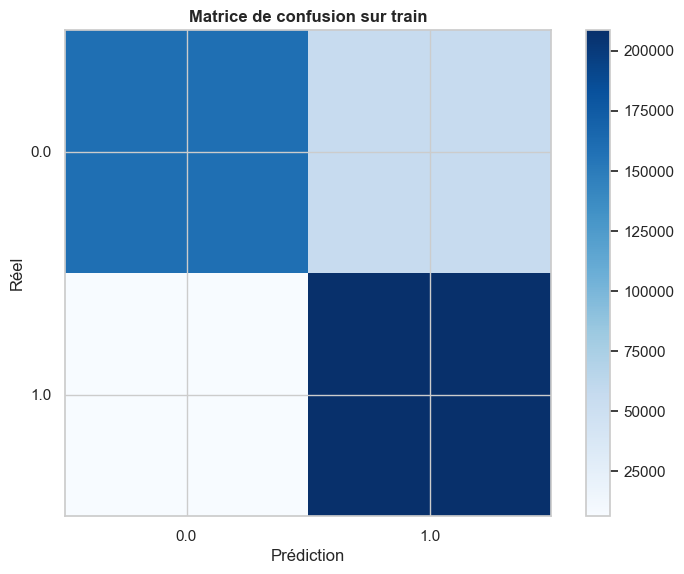

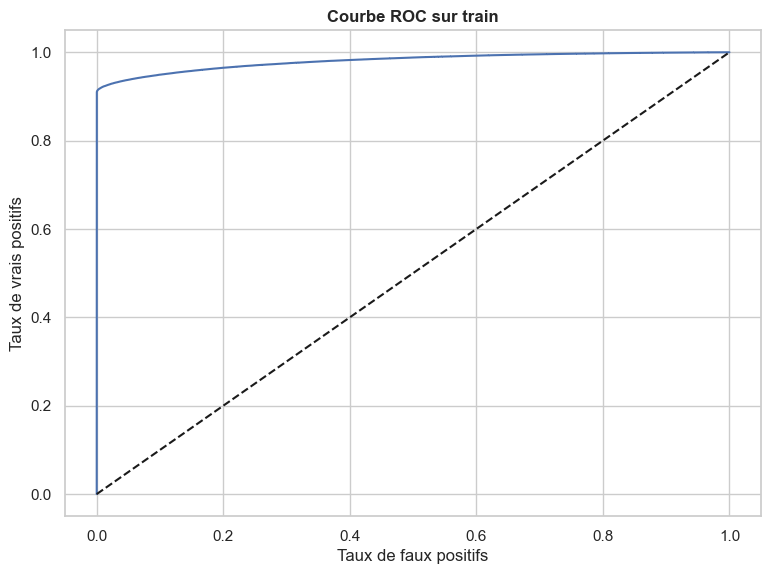

In [222]:
cf_matrix_roc_auc(grid, y_train_resampled, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

Résultats sur le jeu de données test:
Score ROC-AUC: 0.75
Coefficient de détermination (R2): -2.71
Erreur quadratique moyenne (MSE): 0.27


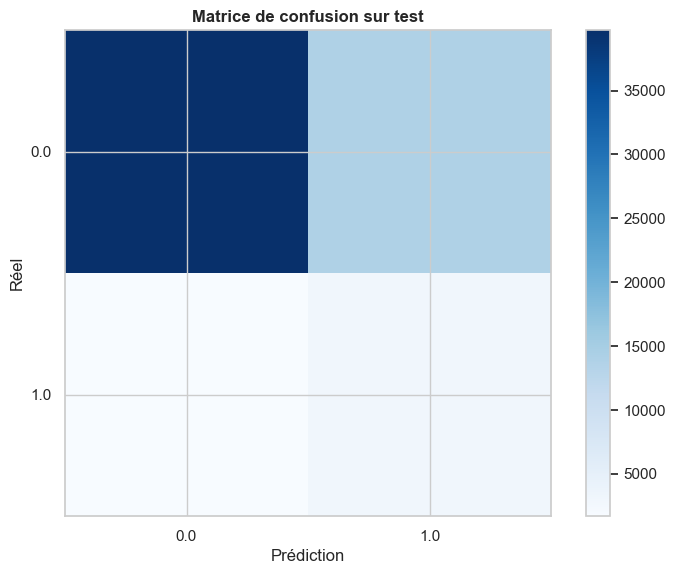

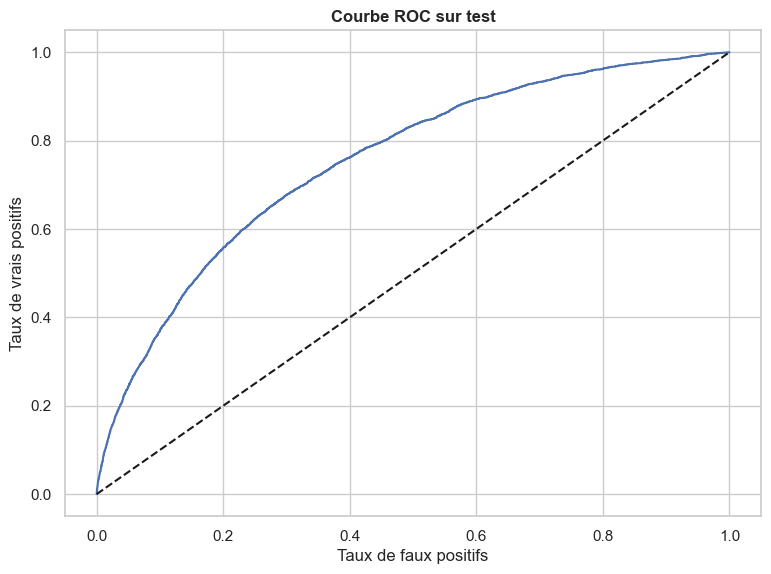

In [223]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores & backup best_estimator

In [224]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LightGBM'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LightGBM'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LightGBM'),'Time'] = round(end1-start1,4)

In [225]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LightGBM'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LightGBM'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LightGBM'),'Time'] = round(end2-start2,4)

In [226]:
# On conserve ces résultats pour un graphique comparatif
LightGBM_y_pred1, LightGBM_y_pred_proba1, LightGBM_y_pred2, LightGBM_y_pred_proba2, LightGBM_roc_auc1, LightGBM_roc_auc2=\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [227]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.7853,0.0285,0.5,
1,Test,Dummy,0.7854,0.0698,0.5,
2,Train,LogReg,0.5574,7.6494,0.7317,
3,Test,LogReg,0.5552,0.3269,0.7347,
4,Train,RandFor,0.222,229.8303,0.9853,
5,Test,RandFor,0.6279,0.3147,0.6719,
6,Train,CatBoost,0.0968,414.8919,0.9968,
7,Test,CatBoost,0.6013,0.7776,0.7172,
8,Train,XGBC,0.0968,414.8919,0.9968,
9,Test,XGBC,0.6013,0.7588,0.7172,


In [117]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 <catboost.core.CatBoostRegressor object at 0x000001B69A127D00>)])

In [118]:
joblib.dump(grid.best_estimator_, 'Models/best_model_LigthGBM.joblib')
# model = joblib.load('Models/best_model_LigthGBM.joblib') to load it back

['Models/best_model_LigthGBM.joblib']

In [119]:
joblib.dump(best_thresh, 'Models/best_thresh_LigthGBM.joblib')
# best_thresh = joblib.load('Models/best_thresh_LigthGBM.joblib') to load it back

['Models/best_thresh_LigthGBM.joblib']

## | Light Gradient Boosting Model Classifier - No Standardization

**Les régressions logistiques** et les algorithmes basés sur des arbres** tels que les **arbres de décision**, les **forêts aléatoires** et le **gradient boosting** ne sont pas sensibles à l'ampleur des variables. La normalisation n'est donc pas nécessaire avant d'ajuster ces types de modèles.

Néanmoins, j'ai conservé cette étape pour chaque modèle pendant la recherche du meilleur modèle.

Une fois que j'ai trouvé que le LGBM est le meilleur, je vais maintenant **alimenter le même modèle** avec des données d'entraînement **non standardisées**, afin de faciliter l'interprétation par la suite. 

Traduit avec DeepL.com (version gratuite)

### | Model & Gridsearch params definition

In [120]:
# Étape 2 : Appliquer SMOTE sur l'échantillon
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Étape 3 : Créer le pipeline du modèle
pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('classifier', LGBMClassifier(random_state=42))
])

max_depth = [5, 7, 9] #ça n'a pa tourné avec estimators testés avec les valeurs suivantes ([100,200,300]/[3,5,7])
subsample = [0.5, 0.75, 0.9]
#reg_lambda = [1e-3, 1e-2, 1e-1, 1, 2]
#colsample_bytree = [0.95, 0.97, 0.99] cet hyperparamètre a planté mon code #nb de colonnes 

param_grid = {'classifier__max_depth': max_depth,
              'classifier__subsample': subsample}
              #'classifier__reg_lambda': reg_lambda}
              #'classifier__colsample_bytree': colsample_bytree}

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=-1)

# Étape 6 : Ajuster la recherche de grille
start1 = time.time()
grid.fit(X_train_resampled, y_train_resampled)
end1 = time.time()

# Évaluation finale sur le jeu de données de test
y_pred = grid.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(test_accuracy)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 214746, number of negative: 214746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.293839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29063
[LightGBM] [Info] Number of data points in the train set: 429492, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.9219045003604408


In [122]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train_resampled)[:, 1]


# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train_resampled, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train_resampled, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train_resampled, y_pred1)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


  1%|          | 1/100 [00:00<00:29,  3.40it/s]

0.0


  2%|▏         | 2/100 [00:00<00:28,  3.47it/s]

0.010101010101010102


  3%|▎         | 3/100 [00:00<00:28,  3.46it/s]

0.020202020202020204


  4%|▍         | 4/100 [00:01<00:27,  3.47it/s]

0.030303030303030304


  5%|▌         | 5/100 [00:01<00:27,  3.43it/s]

0.04040404040404041


  6%|▌         | 6/100 [00:01<00:27,  3.42it/s]

0.05050505050505051


  7%|▋         | 7/100 [00:02<00:27,  3.43it/s]

0.06060606060606061


  8%|▊         | 8/100 [00:02<00:26,  3.44it/s]

0.07070707070707072


  9%|▉         | 9/100 [00:02<00:26,  3.40it/s]

0.08080808080808081


 10%|█         | 10/100 [00:02<00:27,  3.27it/s]

0.09090909090909091


 11%|█         | 11/100 [00:03<00:26,  3.33it/s]

0.10101010101010102


100%|██████████| 100/100 [00:29<00:00,  3.45it/s]


In [123]:
joblib.dump(grid.best_estimator_, 'Models/best_model_LightGBM_NS.joblib')
# model = joblib.load('Models/best_model_LigthGBM_NS.joblib') to load it back

['Models/best_model_LightGBM_NS.joblib']

In [ ]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_tra
      in : %0.4f' % custom_metric1)
print(classification_report(y_train_resampled, y_pred1))

### | Predict / Test

In [124]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: total: 4.19 s
Wall time: 802 ms


In [125]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.7521
custom_score_test : 0.5276
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83     53686
         1.0       0.17      0.64      0.27      4576

    accuracy                           0.73     58262
   macro avg       0.57      0.69      0.55     58262
weighted avg       0.90      0.73      0.79     58262



### | AUC du fichier train “cross-validé” | choix meilleur modèle

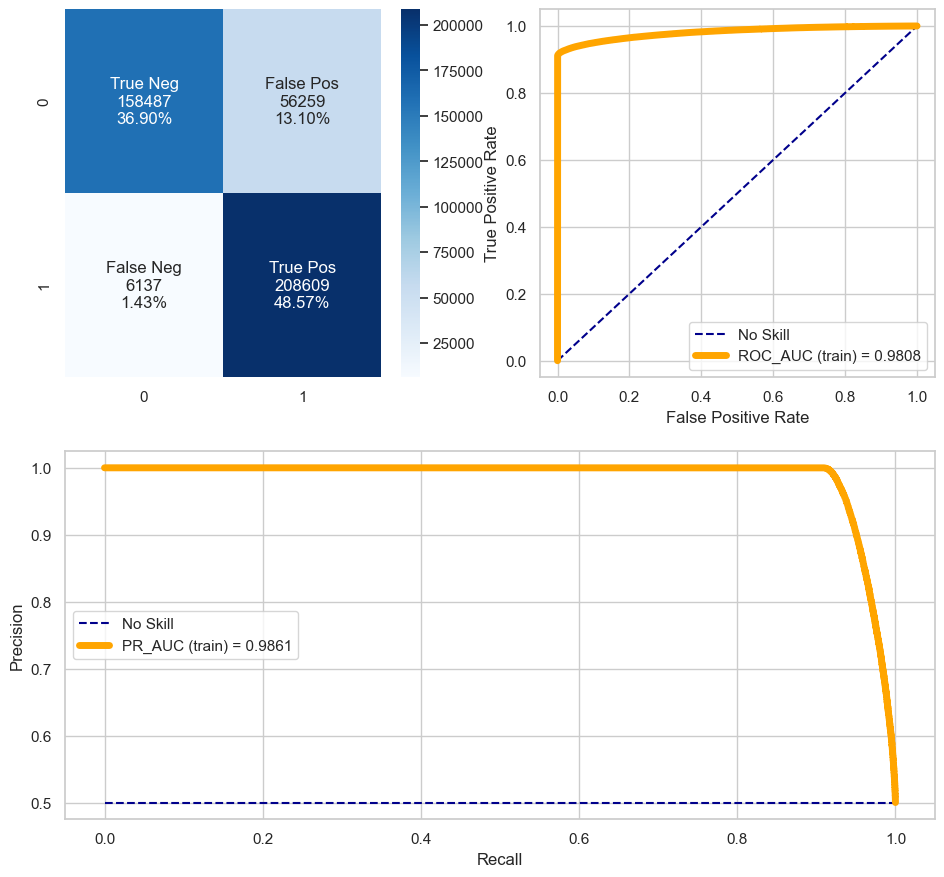

In [126]:
cf_matrix_roc_auc(grid, y_train_resampled, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

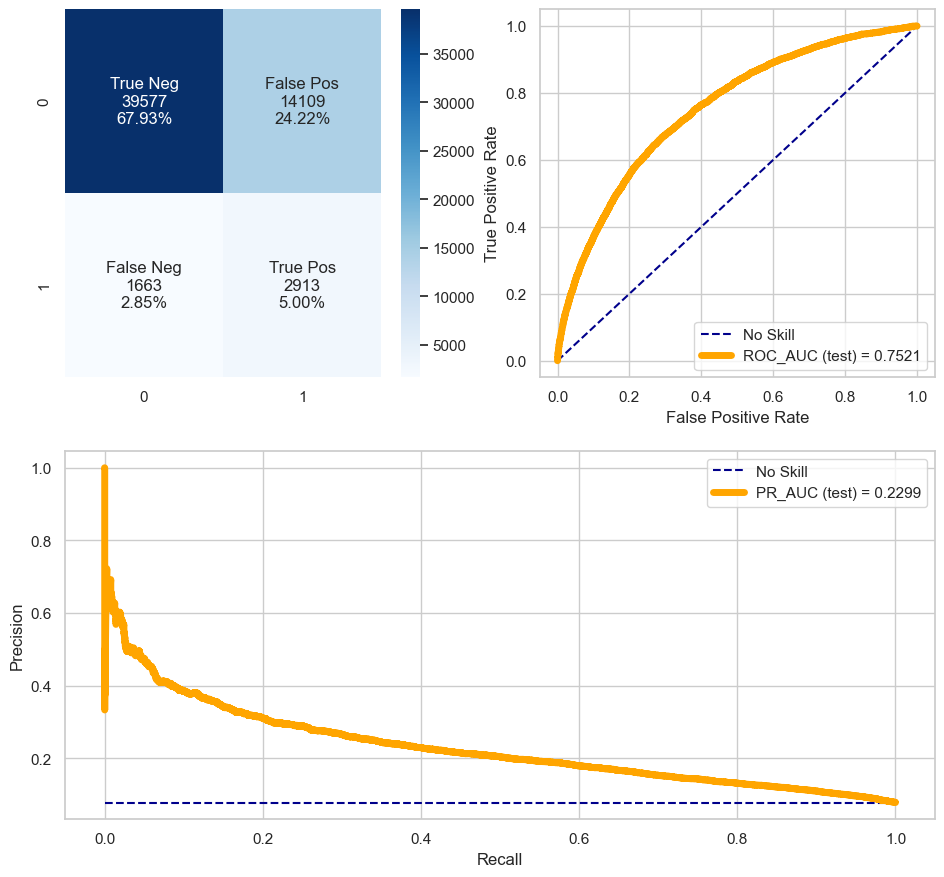

In [127]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores & backup best_estimator

In [128]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LightGBM_NS'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LightGBM_NS'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LightGBM_NS'),'Time'] = round(end1-start1,4)

In [129]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LightGBM_NS'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LightGBM_NS'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LightGBM_NS'),'Time'] = round(end2-start2,4)

In [130]:
# On conserve ces résultats pour un graphique comparatif
LightGBM_NS_y_pred1, LightGBM_NS_y_pred_proba1, LightGBM_NS_y_pred2, LightGBM_NS_y_pred_proba2, LightGBM_NS_roc_auc1, LightGBM_NS_roc_auc2=\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [228]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.7853,0.0285,0.5,
1,Test,Dummy,0.7854,0.0698,0.5,
2,Train,LogReg,0.5574,7.6494,0.7317,
3,Test,LogReg,0.5552,0.3269,0.7347,
4,Train,RandFor,0.222,229.8303,0.9853,
5,Test,RandFor,0.6279,0.3147,0.6719,
6,Train,CatBoost,0.0968,414.8919,0.9968,
7,Test,CatBoost,0.6013,0.7776,0.7172,
8,Train,XGBC,0.0968,414.8919,0.9968,
9,Test,XGBC,0.6013,0.7588,0.7172,


In [132]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()),
                ('classifier',
                 LGBMClassifier(max_depth=9, random_state=42, subsample=0.5))])

In [133]:
joblib.dump(grid.best_estimator_, 'Models/best_model_LightGBM_NS.joblib')
# model = joblib.load('Models/best_model_LigthGBM_NS.joblib') to load it back

['Models/best_model_LightGBM_NS.joblib']

In [134]:
joblib.dump(best_thresh, 'Models/best_thresh_LightGBM_NS.joblib')
# best_thresh = joblib.load('Models/best_thresh_LigthGBM_NS.joblib') to load it back

['Models/best_thresh_LightGBM_NS.joblib']

# | Selecting best model

## | Creating lists to feed graphic functions

In [229]:
pred_proba_1 = [Dummy_y_pred_proba1, LogReg_y_pred_proba1, RandFor_y_pred_proba1,\
                CatBoost_y_pred_proba1, XGBC_y_pred_proba1, LightGBM_y_pred_proba1,\
                LightGBM_NS_y_pred_proba1]

In [230]:
pred_proba_2 = [Dummy_y_pred_proba2, LogReg_y_pred_proba2, RandFor_y_pred_proba2,\
                CatBoost_y_pred_proba2, XGBC_y_pred_proba2, LightGBM_y_pred_proba2,\
                LightGBM_NS_y_pred_proba2]

In [231]:
predictions_1 = [Dummy_y_pred1, LogReg_y_pred1, RandFor_y_pred1, CatBoost_y_pred1,\
                 XGBC_y_pred1, LightGBM_y_pred1, LightGBM_NS_y_pred1]

In [232]:
predictions_2 = [Dummy_y_pred2, LogReg_y_pred2, RandFor_y_pred2, CatBoost_y_pred2,\
                 XGBC_y_pred2, LightGBM_y_pred2, LightGBM_NS_y_pred2]

In [233]:
roc_auc_1 = [Dummy_roc_auc1, LogReg_roc_auc1, RandFor_roc_auc1, CatBoost_roc_auc1,\
             XGBC_roc_auc1, LightGBM_roc_auc1, LightGBM_NS_roc_auc1]

In [234]:
roc_auc_2 = [Dummy_roc_auc2, LogReg_roc_auc2, RandFor_roc_auc2, CatBoost_roc_auc2,\
             XGBC_roc_auc2, LightGBM_roc_auc2, LightGBM_NS_roc_auc2]

## | Results visualization | recapitulative table & graphs

### | Confusion Matrix

In [235]:
print(f"Le jeu d'entrainement comporte {sum(y_train==1)} \"Default\" pour {sum(y_train==0)} \"No Default\"")

Le jeu d'entrainement comporte 18302 "Default" pour 214746 "No Default"


ValueError: Found input variables with inconsistent numbers of samples: [233048, 429492]

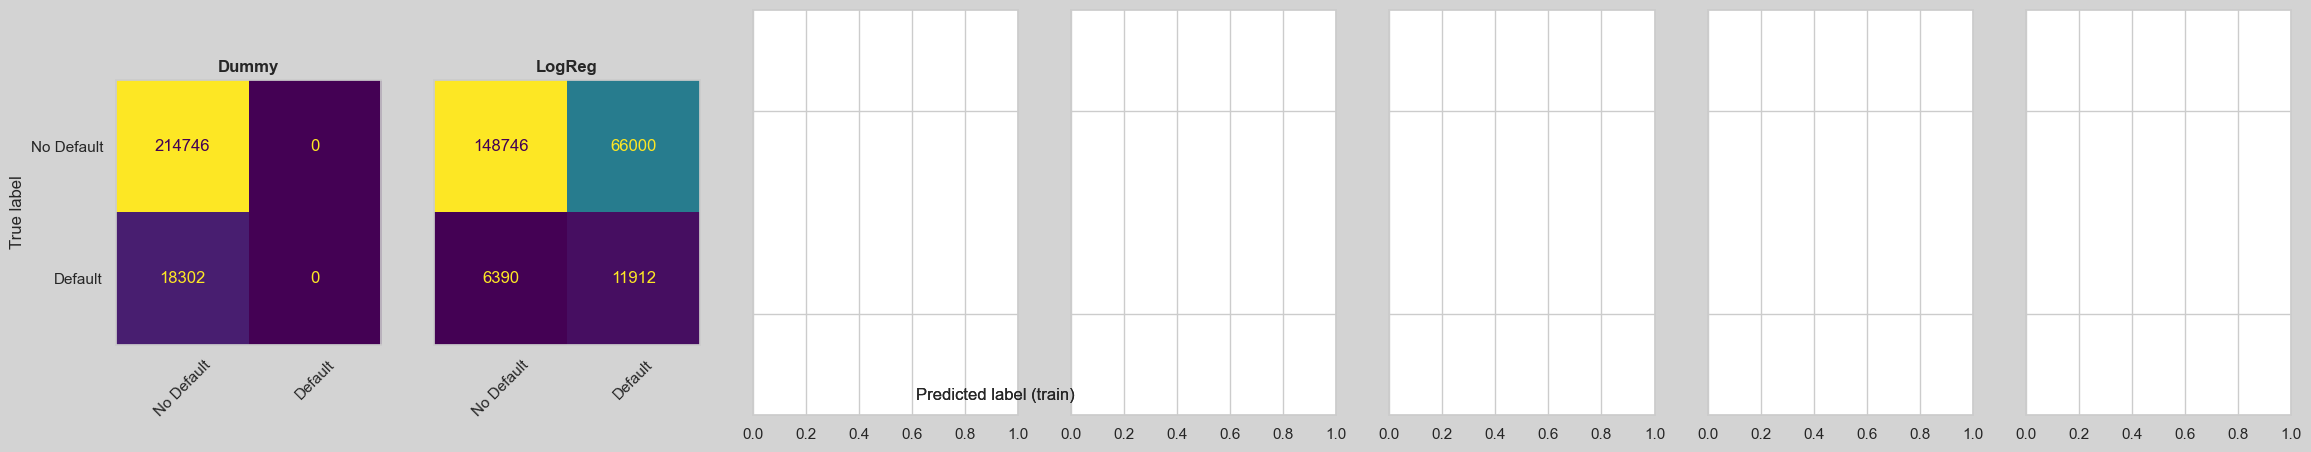

In [236]:
cf_matrix_compare("train")

In [237]:
print(f"Le jeu de test comporte {sum(y_test==1)} \"Default\" pour {sum(y_test==0)} \"No Default\"")

Le jeu de test comporte 4576 "Default" pour 53686 "No Default"


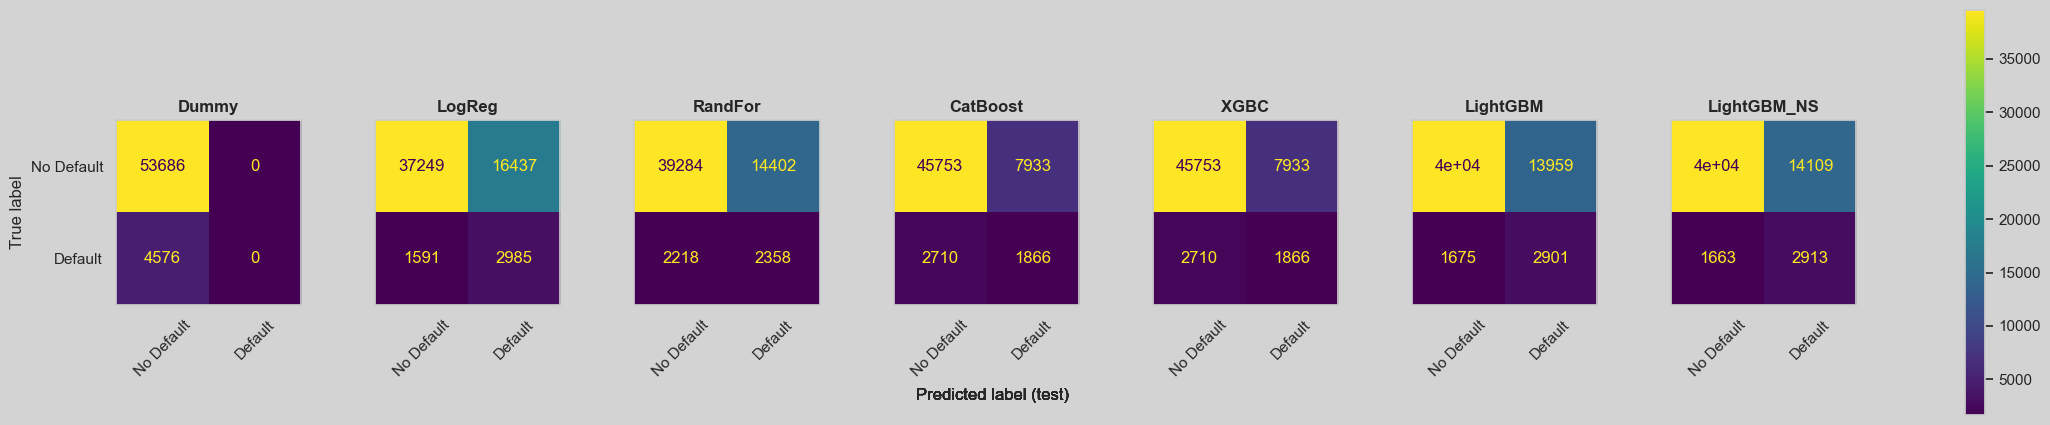

In [238]:
cf_matrix_compare("test")

### | ROC and PR Curves

ValueError: Found input variables with inconsistent numbers of samples: [233048, 429492]

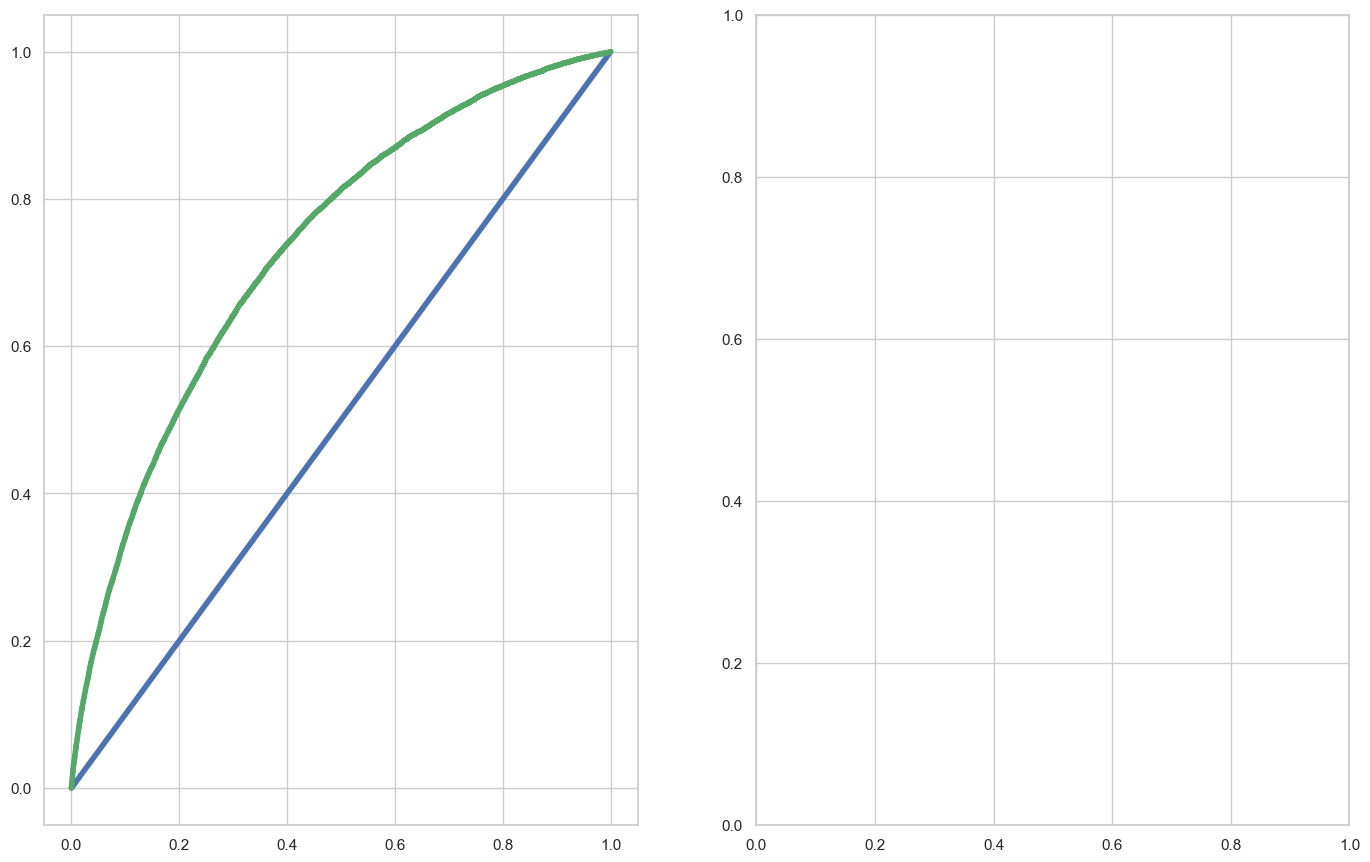

In [240]:
pr_auc_train = auc_compare("train")[0]

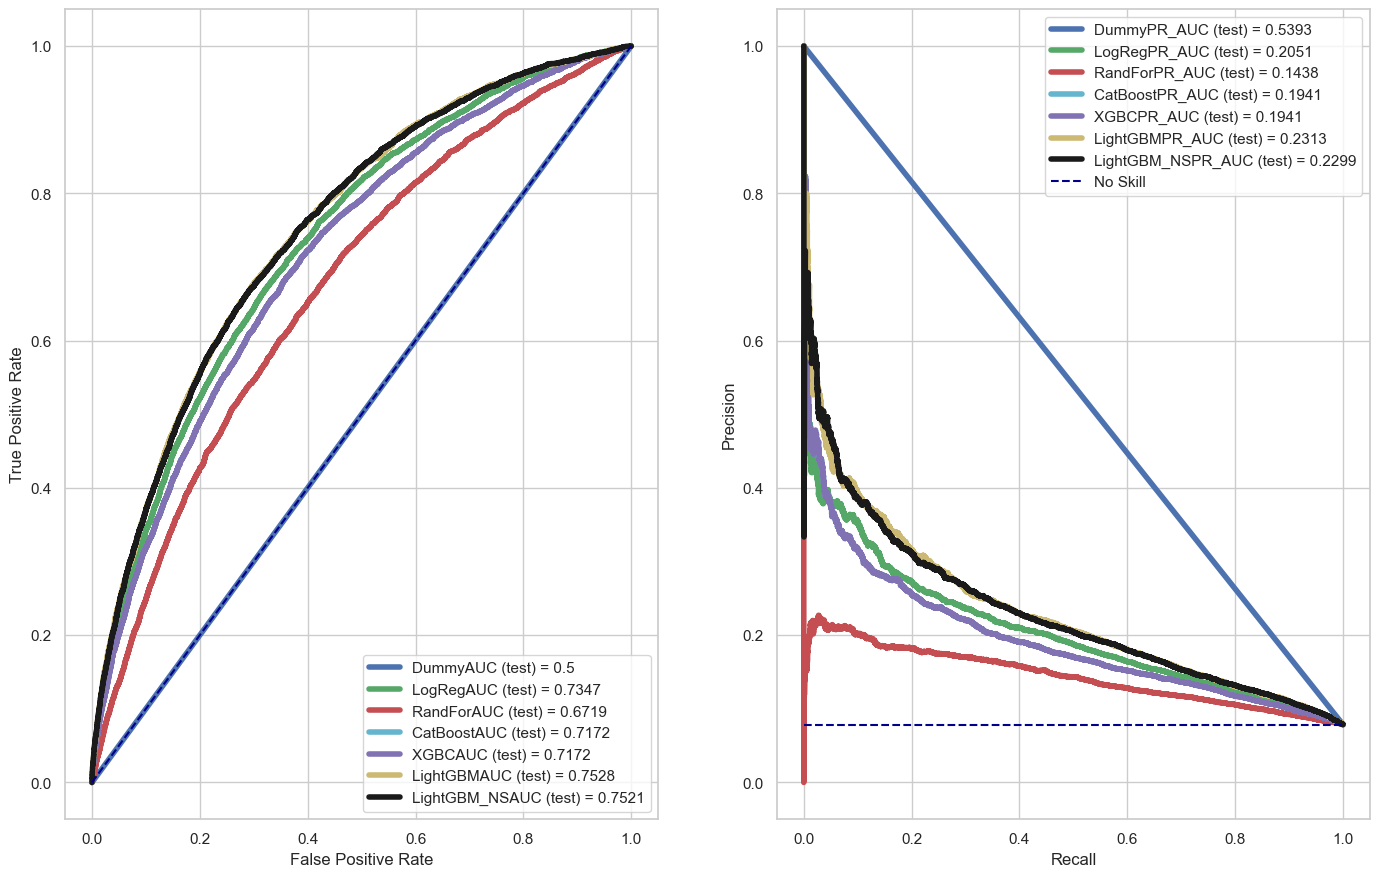

In [241]:
pr_auc_test = auc_compare("test")[1]

In [243]:
pr_auc_dict_train= {'Data':'Train', 'Model':model_names, 'PR_AUC':pr_auc_train}
pr_auc_dict_test= {'Data':'Test', 'Model':model_names, 'PR_AUC':pr_auc_test}

NameError: name 'pr_auc_train' is not defined

In [244]:
# Adding PR_AUC results to the final dataframe
df_auc_train = pd.DataFrame.from_dict(pr_auc_dict_train)
df_auc_test = pd.DataFrame.from_dict(pr_auc_dict_test)
df_auc_tot = pd.concat([df_auc_train, df_auc_test], axis=0)
model_scores_m = pd.merge(model_scores, df_auc_tot, how='left', on=['Data', 'Model'], suffixes=('_x', None))
model_scores_m.drop(columns='PR_AUC_x', inplace=True)
model_scores = model_scores_m

NameError: name 'pr_auc_dict_train' is not defined

In [245]:
model_scores.loc[model_scores["Data"]=="Train",:].sort_values(by='Custom_score', ascending=True)

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
6,Train,CatBoost,0.0968,414.8919,0.9968,
8,Train,XGBC,0.0968,414.8919,0.9968,
4,Train,RandFor,0.222,229.8303,0.9853,
10,Train,LightGBM,0.2732,663.3996,0.9807,
12,Train,LightGBM_NS,0.2739,583.0824,0.9808,
2,Train,LogReg,0.5574,7.6494,0.7317,
0,Train,Dummy,0.7853,0.0285,0.5,


Sur l'étape de l'entrainement, le modèle **CatBoost** ressort **premier** sur les critères de :
-  Custom Score
-  ROC_AUC
-  PR_AUC (Dummy mis à part)

Il est par ailleurs **3rd** sur les critères de :
-  Temps d'entrainement (derrière Dummy / Log Reg / Rand For)

In [246]:
model_scores.loc[model_scores["Data"]=="Test",:].sort_values(by='Custom_score', ascending=True)

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
11,Test,LightGBM,0.5271,1.0123,0.7528,
13,Test,LightGBM_NS,0.5276,0.8024,0.7521,
3,Test,LogReg,0.5552,0.3269,0.7347,
7,Test,CatBoost,0.6013,0.7776,0.7172,
9,Test,XGBC,0.6013,0.7588,0.7172,
5,Test,RandFor,0.6279,0.3147,0.6719,
1,Test,Dummy,0.7854,0.0698,0.5,


Sur l'étape de validation, le modèle **LightGBM** se révèle **le plus performant** sur les critères de :
-  Custom_score
-  ROC_AUC
-  PR_AUC (Dummy à part)

In [247]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.7853,0.0285,0.5,
1,Test,Dummy,0.7854,0.0698,0.5,
2,Train,LogReg,0.5574,7.6494,0.7317,
3,Test,LogReg,0.5552,0.3269,0.7347,
4,Train,RandFor,0.222,229.8303,0.9853,
5,Test,RandFor,0.6279,0.3147,0.6719,
6,Train,CatBoost,0.0968,414.8919,0.9968,
7,Test,CatBoost,0.6013,0.7776,0.7172,
8,Train,XGBC,0.0968,414.8919,0.9968,
9,Test,XGBC,0.6013,0.7588,0.7172,
